<a href="https://colab.research.google.com/github/tyfmanlapaz/Data-Science/blob/deep-learning/SuperFinal_A3_Pneumonia_Classification_with_CNN_and_Friends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Evaluating the efficacy of a Conventional CNN model and Pre-trained CNN model on Detecting Pneumonia from Chest X-ray Images**

In this activity, we will be developing a conventional CNN and as well as a pre-trained CNN model for classificying Pneumonia from Chest X-ray images

# Section 1: Data Collection

**1.1 Importing Libraries**

In [25]:
# load libraries
import pandas as pd
import numpy as np
import random
import os
import glob
from google.colab import drive
import itertools
from PIL import Image
import time   # for training time calculations

# plotting libraries
import seaborn as sns
import matplotlib as mat
import matplotlib.pyplot as plt
%matplotlib inline
#sns.set() # Setting seaborn as default style even if use only matplotlib

# DL and ML Libraries
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model # for plotting models
from tensorflow.keras.applications import VGG16, ResNet50V2, MobileNetV2

# for Hyperparameter tuning
from keras.regularizers import l1, l2, l1_l2

# Metrics and Splitting
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# environment seeds for reproducibility
seed_value = 42
from numpy.random import seed
seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)                   # Set the random seed in tensorflow at graph level
os.environ['PYTHONHASHSEED'] = str(seed_value)   # Set the seed for hash based operations in python
os.environ['TF_DETERMINISTIC_OPS'] = '1'         # Set seed for TF operations

pd.options.display.max_colwidth = 200
sns.set_style('whitegrid')

In [ ]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [26]:
# code to get the execution time of each cell block in ms
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.7 MB/s eta 0:00:00
time: 269 µs (started: 2024-06-21 17:16:15 +00:00)


In [ ]:
# Check if a GPU device is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available
time: 617 µs (started: 2024-06-18 17:28:41 +00:00)


**1.2 Authenticating and Mounting the Dataset**

In [27]:
# authenticating and mounting GDrive
drive.mount('/content/drive')

#extracting contents of the zip file and loading it to gcolab
from zipfile import ZipFile

# defining path to zip file
cxr_zip_path = '/content/drive/My Drive/GoogleColab/Datasets/CXR.zip'

# creating directory to extract files
cxr_extract_dir = '/content/datasets'
os.makedirs(cxr_extract_dir, exist_ok=True)

# extract zip files to gcolab storage/directory
with ZipFile(cxr_zip_path, 'r') as cxr_zip_ref:
    cxr_zip_ref.extractall(cxr_extract_dir)

# define main dataset directory
main_dir = cxr_extract_dir

#train, test, val directories
train_dir = os.path.join(main_dir, 'train')
val_dir = os.path.join(main_dir, 'val')
test_dir = os.path.join(main_dir, 'test')

Mounted at /content/drive
time: 50.9 s (started: 2024-06-21 17:16:16 +00:00)


**1.3 Loading the PreSplit Datasets into Dataframes**

In [28]:
labels = ['PNEUMONIA', 'NORMAL']  # Define the labels

# 1. function to get file paths
def get_file_paths(directory):
    file_paths = []
    # get directory structures
    for rootdir, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(rootdir, file)
            size = os.path.getsize(file_path) / 1024 #in KB
            file_paths.append({'file': file_path, 'size_kb': round(size,3)})
    return file_paths

# 2. function to create dataframes
def generate_dataframe(path=None, labels=None):
    data = []
    for label in labels:
        category_path = os.path.join(path, label)
        file_sizes = get_file_paths(category_path)
        data.extend(file_sizes)
    df = pd.DataFrame(data)
    return df

#create dataframes
train_df = generate_dataframe(train_dir, labels)
test_df = generate_dataframe(test_dir, labels)
val_df = generate_dataframe(val_dir, labels)

# 3. function get class labels
def get_class_label(file_path):
    if 'PNEUMONIA' in file_path:
        return 'pneumonia'
    elif 'NORMAL' in file_path:
        return 'normal'
    else:
        return 'unknown'
directory_df_dict = {'train': train_df, 'val': val_df, 'test': test_df}

# apply function to get labels
for df in directory_df_dict.values():
    df['label'] = df['file'].apply(get_class_label)

# 4. function get dimensions
def get_file_dimensions(file_path):
    try:
        with Image.open(file_path) as img:
            return img.size
    except Exception as e:
        print(f"Error reading image {file_path}: {e}")

# apply function to get dimensions
for name, df in directory_df_dict.items():
    df['dimensions'] = df['file'].apply(get_file_dimensions)

time: 469 ms (started: 2024-06-21 17:38:47 +00:00)


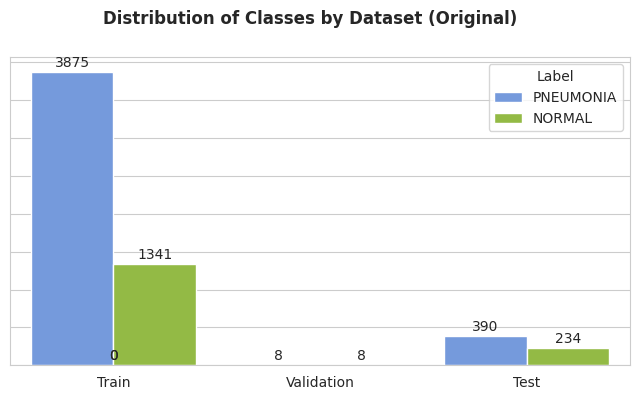

time: 298 ms (started: 2024-06-21 17:38:51 +00:00)


In [29]:
#file count check function including plotting thr distribution per label
def get_file_counts():


  # Initialize a list to hold the data
  data = []

  # Loop through labels and collect file counts for each set
  for label in labels:
      train_num_data = len(os.listdir(os.path.join(train_dir, label)))
      val_num_data = len(os.listdir(os.path.join(val_dir, label)))
      test_num_data = len(os.listdir(os.path.join(test_dir, label)))
      # Append the counts to the data list
      data.append({'Label': label, 'Set': 'Train', 'Count': train_num_data})
      data.append({'Label': label, 'Set': 'Validation', 'Count': val_num_data})
      data.append({'Label': label, 'Set': 'Test', 'Count': test_num_data})

  # Create a DataFrame from the data list
  df = pd.DataFrame(data)

  # Create the bar plot using Seaborn
  plt.figure(figsize=(8, 4))
  plt.suptitle('Distribution of Classes by Dataset (Original)', fontsize=12, fontweight='bold', ha='center', y=1)
  #barplot = sns.barplot(x='Set', y='Count', hue='Label', data=df, palette=['mediumpurple', 'yellowgreen'])
  barplot = sns.barplot(x='Set', y='Count', hue='Label', data=df, palette=['cornflowerblue', 'yellowgreen'])
  # Add numbers on top of the bars
  for p in barplot.patches:
      barplot.annotate(format(p.get_height(), '.0f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center', va = 'center',
                      xytext = (0, 7),
                      textcoords = 'offset points')
  plt.xlabel(None)
  plt.ylabel(None)
  barplot.tick_params(axis='y', which='both', left=False, labelleft=False)   # Remove the y-axis ticks

get_file_counts() # call function

In [30]:
# Function to create the dataset distribution pie chart plots
def create_distribution_plots(data_dict, title):
  fig, axes = plt.subplots(1, 3, figsize=(10, 4))
  fig.suptitle(f'Class Distribution by Percentage ({title})' , fontsize=12, fontweight='bold', ha='center', y=1)
  #chart_colors = ['cornflowerblue','thistle']
  chart_colors = ['mediumpurple', 'yellowgreen']
  subtitle_props = {'fontsize': 10, 'ha': 'center'}
  index = 0

  for split_name, data_name in data_dict.items():
    label_counts = data_name['label'].value_counts() #set labels
    # Subplots
    data_wedge = axes[index].pie(label_counts, autopct='%1.0f%%', startangle=90, colors=chart_colors)
    axes[index].set_title(split_name, subtitle_props)
    index = index + 1

  # Create a legend outside the plot using wedges and labels from subplots
  labels = label_counts.index.to_numpy()  # Assuming class labels are in the index
  legend_patches = data_wedge[0]  # Get wedge patches from the first subplot
  plt.legend(legend_patches, labels, loc='upper right', fontsize=10)
  plt.show()

# call function to plot datasets before pre-processing
original_data_dict = {'Training': train_df, 'Validation': val_df, 'Testing': test_df}

time: 899 µs (started: 2024-06-21 17:39:00 +00:00)


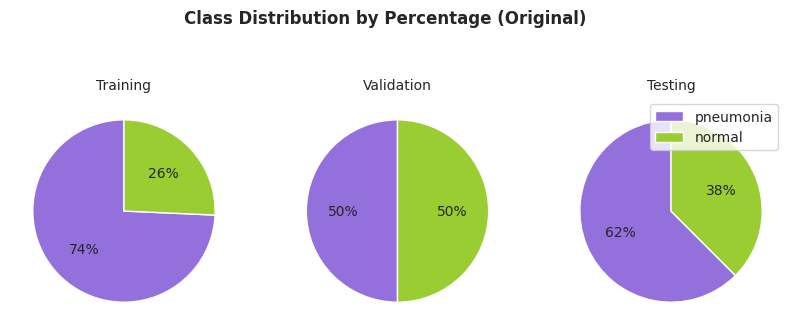

time: 198 ms (started: 2024-06-21 17:39:05 +00:00)


In [31]:
#plot the original distribution of the datasets
create_distribution_plots(original_data_dict, 'Original')

In [32]:
# get dataframe shapes
print('Dataset Shapes: \n' + '+' * 55)
print('Train Set (train_dir):',train_df.shape)
print('Test Set (test_dir):',test_df.shape)
print('Validation Set (val_dir): ',val_df.shape)

#note: since the images have only 2 dimensions, then the image is considered greyscale.

Dataset Shapes: 
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
Train Set (train_dir): (5216, 4)
Test Set (test_dir): (624, 4)
Validation Set (val_dir):  (16, 4)
time: 750 µs (started: 2024-06-21 17:39:11 +00:00)


In [8]:
# get sample rows from train dataframe
train_df.sample(10)

file  \
318   /content/datasets/train/PNEUMONIA/person1180_bacteria_3128.jpeg   
4221                 /content/datasets/train/NORMAL/IM-0417-0001.jpeg   
5028         /content/datasets/train/NORMAL/NORMAL2-IM-0939-0001.jpeg   
4419         /content/datasets/train/NORMAL/NORMAL2-IM-0927-0001.jpeg   
4300         /content/datasets/train/NORMAL/NORMAL2-IM-1154-0001.jpeg   
1247  /content/datasets/train/PNEUMONIA/person1730_bacteria_4558.jpeg   
5163         /content/datasets/train/NORMAL/NORMAL2-IM-1053-0001.jpeg   
1885      /content/datasets/train/PNEUMONIA/person891_virus_1541.jpeg   
3703  /content/datasets/train/PNEUMONIA/person1198_bacteria_3148.jpeg   
1536   /content/datasets/train/PNEUMONIA/person267_bacteria_1252.jpeg   

       size_kb      label    dimensions  
318     47.015  pneumonia    (960, 696)  
4221   666.521     normal  (1786, 1500)  
5028  1500.010     normal  (2342, 2399)  
4419  2032.224     normal  (2359, 2234)  
4300   637.733     normal  (1744, 1422)  
1247    37.598  pneumonia    (872, 560)  
5163   529.435     normal  (1692, 1372)  
1885    56.087  pneumonia   (1048, 632)  
3703    47.510  pneumonia   (1128, 704)  
1536   103.830  pneumonia   (1300, 890)

In [ ]:
# Understanding Data Labels/Class
print(f'Number of Unique Labels (Class): {train_df.iloc[:,2].nunique()}')
print(f'The Unique Values: {train_df.iloc[:,2].unique()}')

Number of Unique Labels (Class): 2
The Unique Values: ['pneumonia' 'normal']


**1.4 Merge Datasets and Create new Split**

In [33]:
#merge all datasets
combined_df = pd.concat([train_df, val_df,test_df], ignore_index=True)

# split train and test with a ratio of 70:30
train_df, test_df_full = train_test_split(combined_df, test_size=0.3,
                          stratify = combined_df['label'], random_state=seed_value)
# split test_data with validation data with test set
test_df, val_df = train_test_split(test_df_full, test_size=0.5,
                           stratify = test_df_full['label'], random_state=seed_value)

print(f'Combined Dataset Shape: {combined_df.shape}')
print('\n' + '+' * 55)
print('New Train Set:',train_df.shape)
print('New Test Set:',test_df.shape)
print('New Validation Set: ',val_df.shape)

# create new dictionary for resplit datasets
resplit_data_dict = {'Training': train_df, 'Validation': val_df, 'Testing': test_df}

Combined Dataset Shape: (5856, 4)

+++++++++++++++++++++++++++++++++++++++++++++++++++++++
New Train Set: (4099, 4)
New Test Set: (878, 4)
New Validation Set:  (879, 4)
time: 13.7 ms (started: 2024-06-21 17:39:19 +00:00)


**1.4 Visualize Class Distributions**

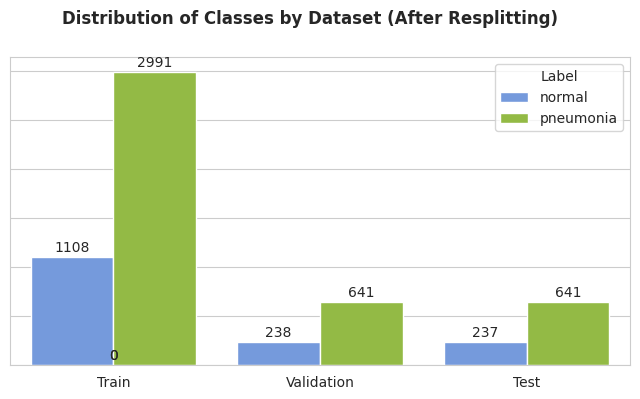

time: 242 ms (started: 2024-06-21 17:39:37 +00:00)


In [34]:
# Define the labels
labels = np.unique(train_df['label'])

# Initialize a list to hold the data
data = []

# Loop through labels and collect file counts for each set
for label in labels:
    train_num_data = len(train_df[train_df['label'] == label])
    val_num_data = len(val_df[val_df['label'] == label])
    test_num_data = len(test_df[test_df['label'] == label])
    # Append the counts to the data list
    data.append({'Label': label, 'Set': 'Train', 'Count': train_num_data})
    data.append({'Label': label, 'Set': 'Validation', 'Count': val_num_data})
    data.append({'Label': label, 'Set': 'Test', 'Count': test_num_data})

# Create a DataFrame from the data list
df = pd.DataFrame(data)

# Create the bar plot using Seaborn
plt.figure(figsize=(8, 4))
plt.suptitle('Distribution of Classes by Dataset (After Resplitting)', fontsize=12, fontweight='bold', ha='center', y=1)
barplot = sns.barplot(x='Set', y='Count', hue='Label', data=df, palette=['cornflowerblue', 'yellowgreen'])
# Add numbers on top of the bars
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 7),
                    textcoords = 'offset points')
plt.xlabel(None)
plt.ylabel(None)
barplot.tick_params(axis='y', which='both', left=False, labelleft=False)   # Remove the y-axis ticks

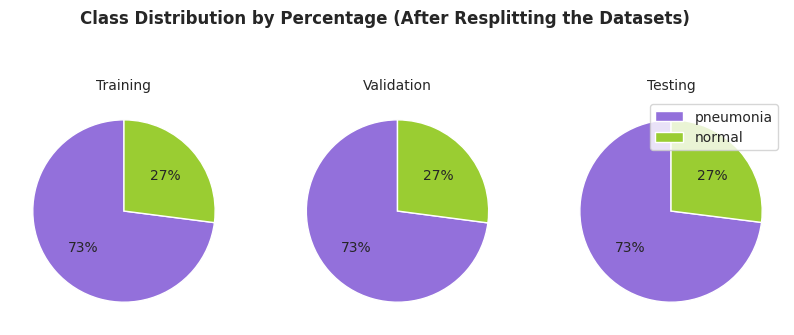

time: 179 ms (started: 2024-06-21 17:39:40 +00:00)


In [35]:
#plot distribution of datasets after splitting
create_distribution_plots(resplit_data_dict, 'After Resplitting the Datasets')

**1.5 Visualize Chest X-Ray Raw Images**

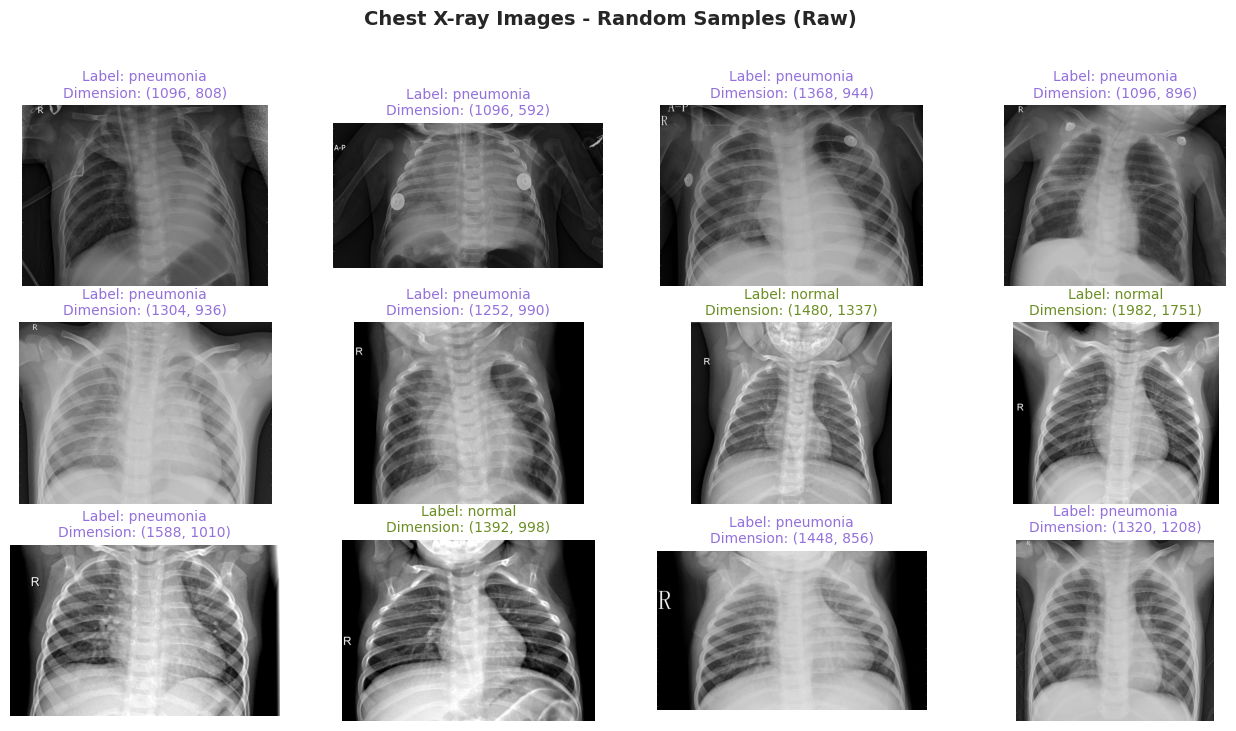

time: 2.02 s (started: 2024-06-21 17:40:10 +00:00)


In [37]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++ #
# 1.5 Visualize Chest X-Ray Raw Images
# ++++++++++++++++++++++++++++++++++++++++++++++++++ #
# check image shape/dimensions and visualize
rows = 3
columns = 4

sample_dataset = combined_df
random_samples = random.sample(range(len(sample_dataset)), rows * columns)

def plot_sample_images(sample_dataset, random_samples, plot_title):
  fig, axes = plt.subplots(rows, columns, figsize = (16, 8))
  fig.suptitle(f'Chest X-ray Images - {plot_title}', fontsize=14, fontweight='bold', ha='center', y = 1)

  for i, index in enumerate(random_samples):
      row = i // columns
      col = i % columns
      img_path = sample_dataset['file'].iloc[index]
      label = f"Label: {sample_dataset['label'].iloc[index]}"
      img = Image.open(img_path)
      axes[row, col].imshow(img, cmap='gray')
      axes[row, col].axis('off')
      if label == "Label: normal":
        axes[row, col].set_title(f'{label}\nDimension: {img.size}', fontsize = 10, ha='center', color='olivedrab')
      else:
        axes[row, col].set_title(f'{label}\nDimension: {img.size}', fontsize = 10, ha='center', color='mediumpurple')
  #plt.tight_layout()
  plt.show()
# these image sizes have different dimensions

#plot random samples from raw dataset
plot_sample_images(sample_dataset, random_samples, 'Random Samples (Raw)')

Number of Images less than 15kb: 76


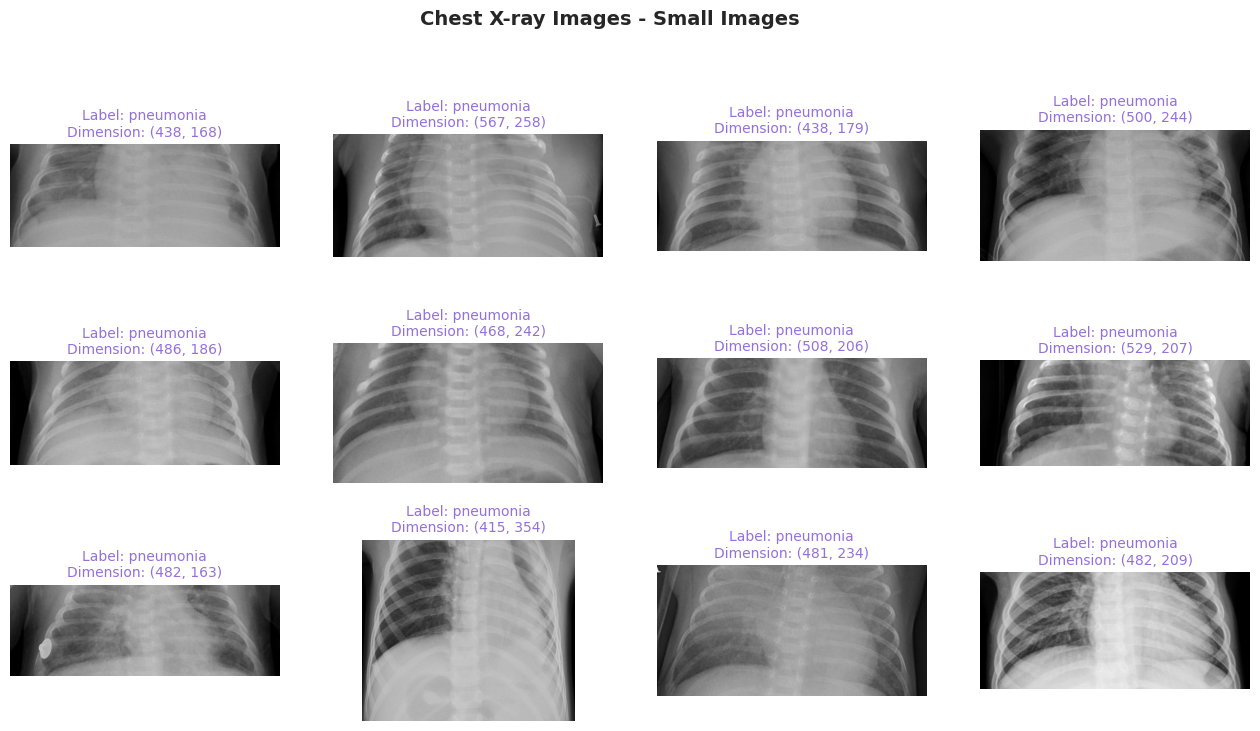

time: 1.64 s (started: 2024-06-21 17:41:47 +00:00)


In [38]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++ #
# 1.6 Determine Optimal Image Size for models
# ++++++++++++++++++++++++++++++++++++++++++++++++++ #
# checking for file sizes lower than 10kb to determine if we can use 256 or 224
# optimal image size for CNN is 256
# but if we have image dimensions less than 256 then use 224 as this also the optimal size for VGG16
small_images_df = sample_dataset
small_images_df = sample_dataset[(small_images_df['size_kb'] < 15)]
random_samples_small = random.sample(range(len(small_images_df)), rows * columns)

print(f'Number of Images less than 15kb: {len(small_images_df)}')

# call custom function to plot sample images
plot_sample_images(small_images_df, random_samples_small, 'Small Images')
# since we have image heights less than 256, we will use 224 pixels to resize the images

# Section 2: Data Preprocessing (Scrubbing)

**2.1 Image Preprocessing**


**From the results of the visualization it can be seen that:**

There are some pictures that tend to tilt to the right
or left.
There are some pictures that show hands and chin.
There are some pictures that seem to be cut off, this can be seen with a size below 10 kb.
There are some pictures that are quite bright and dark
Based on these results, in the preprocessing part it seems that we need to augment random rotation, zoom and also maybe we need color jitter.

In [39]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++ #
# Setting Constants
# ++++++++++++++++++++++++++++++++++++++++++++++++++ #
# chooses the best optimization strategies for data processing within data pipeline.
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 32
image_size = 224  # determined optimal size after image size exploration
input_shape= (224, 224, 3)
init_learn_rate = 0.01

time: 685 µs (started: 2024-06-21 17:47:07 +00:00)


In [40]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++ #
# 2.2 Define Image Preprocessing Functions
# ++++++++++++++++++++++++++++++++++++++++++++++++++ #
def preprocess_image(file_path, label, channels=3):
    img_data = tf.io.read_file(file_path) #read image
    # Decode the image into a tensor
    img_data = tf.image.decode_jpeg(img_data, channels=channels)
    # Resize the image to a fixed size
    img_data = tf.image.resize(img_data, [image_size, image_size])
    # Normalize pixel values [0, 1]
    img_data = tf.cast(img_data, tf.float32) / 255.0
    # Convert of labels to numeric (0 for normal, 1 for pneumonia)
    label = tf.where(tf.math.equal(label, 'normal'), 0, 1)
    return img_data, label

def add_color_jitter(image, brightness_factor=0.02, contrast_factor=0.02, seed=None):
  with tf.device('/CPU:0'):
    image = tf.image.random_brightness(image, max_delta=brightness_factor, seed=seed)
    image = tf.image.random_contrast(image, lower=1-contrast_factor, upper=1+contrast_factor, seed=seed)
    image = tf.image.random_saturation(image, lower=1-contrast_factor, upper=1+contrast_factor, seed=seed)
    image = tf.image.random_hue(image, max_delta=brightness_factor, seed=seed)
    return image

def plot_preprocessed_images(original_img, augmented_img):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original Data')
  plt.imshow(original_img)
  plt.subplot(1,2,2)
  plt.title('Preprocessed Data')
  plt.imshow(augmented_img)
  #plt.axis('off')
  plt.show()

time: 854 µs (started: 2024-06-21 17:47:10 +00:00)


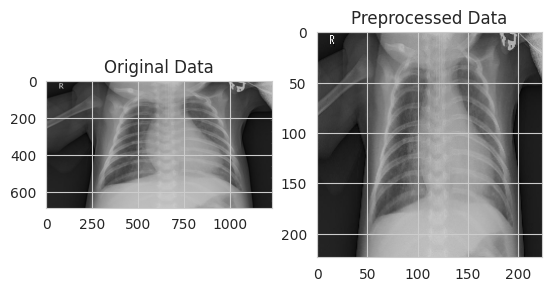

Preprocessed Tensor Shape: (224, 224, 3)


In [28]:
# get sample pneumonia path
pneumonia_sample_path = train_df.query("label=='pneumonia'")['file'].values
pneumonia_sample_path

# visualizing a sample of an augmented data
sample_image_path = '/content/datasets/train/PNEUMONIA/person277_bacteria_1305.jpeg'
orig_img_data = tf.io.read_file(sample_image_path) #read image
orig_img_data = tf.image.decode_jpeg(orig_img_data, channels=3)
orig_img_data = tf.cast(orig_img_data, tf.float32) / 255.0  # convert to float

# preprocess image
img, label = preprocess_image(sample_image_path,'pneumonia', 3)

# test the color jitter data augmentation
color_jiter_test = add_color_jitter(img,seed=seed_value)

# plot sample image with augmentation
plot_preprocessed_images(orig_img_data, color_jiter_test)
print(f'Preprocessed Tensor Shape: {img.shape}')

**2.2 Data Augmentation**

***Augment the datasets to handle the class imbalances to help reduce overfitting.***

First, build a new generator for validation and testing data.

Why can't use the same generator as for the training data?

It normalizes each image per batch, meaning that it uses batch statistics. We should not do this with the test and validation data, since in a real life scenario we don't process incoming images a batch at a time (we process one image at a time). Knowing the average per batch of test data would effectively give our model an advantage (The model should not have any information about the test data). What we need to do is to normalize incoming test data using the statistics computed from the training set.

In [41]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++ #
# 2.2 Data Augmentation
# ++++++++++++++++++++++++++++++++++++++++++++++++++ #
def augment_training_image(img, label):
    img = add_color_jitter(img, seed=seed_value)
    return img, label

def augment_validation_image(img, label):
    # to add augmentation techniques as needed
    return img, label

layers_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomRotation(0.02),
            tf.keras.layers.RandomZoom(height_factor=(0.03, 0.1),width_factor=(0.03, 0.1)),
        ])

# helper function to optimize preprocessing and to preprocess images too
def prepare_preprocessing(dataset, batch_size=32,shuffle=False, augment_layers=False, augment_custom=False):
    # Map preprocess_image function to dataset
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.cache()

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    if augment_custom:
        dataset = dataset.map(augment_training_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if augment_layers:
        dataset = dataset.map(lambda x, y: (layers_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE)

    return dataset

time: 11.9 ms (started: 2024-06-21 17:47:20 +00:00)


In [42]:
# Create dataset using tf.data.Dataset.from_tensor_slices
train_image_paths = train_df['file'].values
train_labels = train_df['label'].values

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
training_ds= prepare_preprocessing(train_dataset, batch_size, shuffle=False, augment_layers=False, augment_custom=True)

# create validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_df['file'].values, val_df['label'].values))
validation_ds = prepare_preprocessing(val_dataset,batch_size, shuffle=False)

# create test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_df['file'].values, test_df['label'].values))
testing_ds = prepare_preprocessing(test_dataset, batch_size, shuffle=False)

# check dataset shapes after execution
for images, labels in training_ds.take(1):
    print(f"\nTrain Dataset Batch Shape: {images.shape}")
    print(f"Labels: {labels}")
    print('\n' + '+'*75)

for images, labels in validation_ds.take(1):
    print(f"Validation Dataset Batch Shape: {images.shape}")
    print(f"Labels: {labels}")
    print('\n' + '+'*75)

for images, labels in testing_ds.take(1):
    print(f"Testing Dataset Batch Shape: {images.shape}")
    print(f"Labels: {labels}")
    print('\n' + '+'*75)


Train Dataset Batch Shape: (32, 224, 224, 3)
Labels: [1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1]

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Validation Dataset Batch Shape: (32, 224, 224, 3)
Labels: [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0]

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Testing Dataset Batch Shape: (32, 224, 224, 3)
Labels: [0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 1 1 1 0 1 0 1 1 0]

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
time: 563 ms (started: 2024-06-21 17:47:24 +00:00)


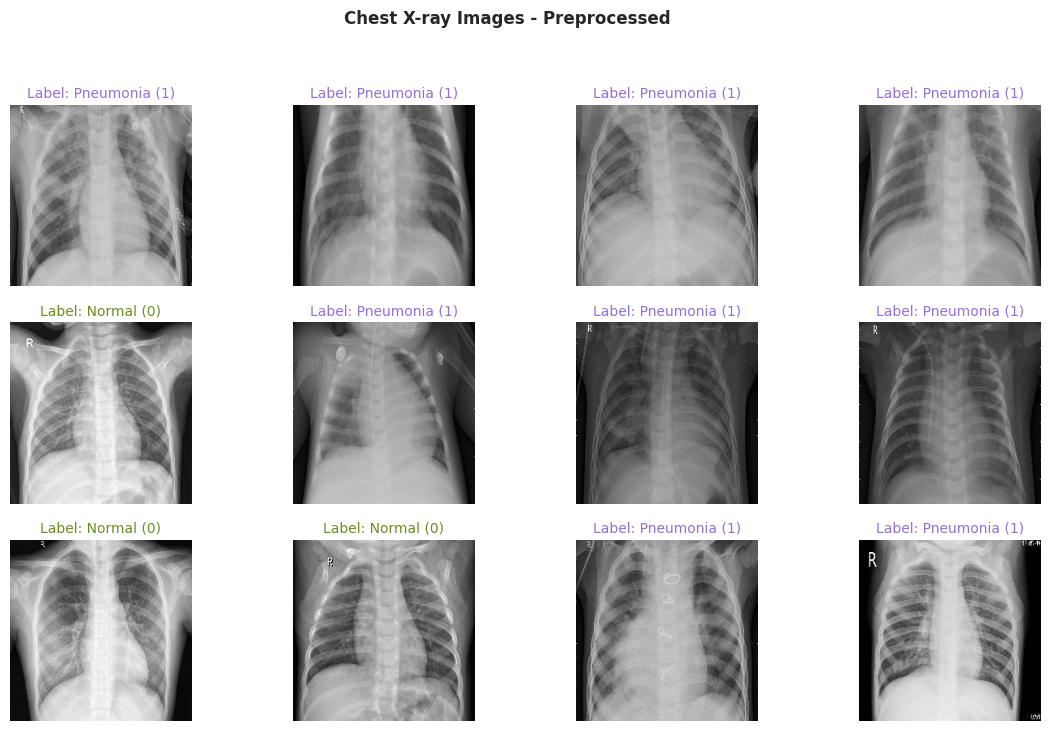

time: 1.35 s (started: 2024-06-21 17:49:45 +00:00)


In [47]:
# checking one batch from training dataset after preprocessing
fig, axes = plt.subplots(rows, columns, figsize = (14, 8))
fig.suptitle(f'Chest X-ray Images - Preprocessed', fontsize=12, fontweight='bold', ha='center', y = 1)

for images, labels in training_ds.take(1):
  for i in range(12):
        plt.subplot(rows, columns, i + 1)
        plt.imshow(images[i])
        if labels[i] == 0:
            plt.title(f'Label: Normal ({labels[i]})', fontsize = 10, ha='center', color='olivedrab')
        else:
            plt.title(f'Label: Pneumonia ({labels[i]})', fontsize = 10, ha='center', color='mediumpurple')
        plt.axis('off')
  plt.show()
# these image sizes have now the same dimensions

**2.3 Class Weights**

Since data augmentation alone is not optimal to treat class imbalances, class weights are needed to compensate the imbalance in the dataset.

By assigning higher weights to the minority class (Normal) and lower weights to the majority class (Pneumonia), the algorithm can be encouraged to pay more attention to the minority class during training.

In [ ]:
#function to calculate class weights to handle imbalance
def calculate_class_weights():
  from sklearn.utils import class_weight
  y_train = train_df['label']
  class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train.values), y=y_train)
  class_weights = dict(enumerate(class_weights))
  print("Class Weights:")
  print(class_weights)

class_weights = calculate_class_weights() # calc class weights

Class Weights:
{0: 1.8497292418772564, 1: 0.6852223336676697}


In [ ]:
np.unique(train_df['label'].values)

array(['normal', 'pneumonia'], dtype=object)

**Modelling Helper Custom Functions**

In [2]:
# plot accuracy and loss evolution for a model
def plot_history(model_hist, model, model_name):
  plt.figure(figsize=(16, 8))

  plt.subplot(2, 2, 1)
  plt.plot(model_hist.history['loss'], label='Train Loss', linestyle='solid', marker='o', color = 'yellowgreen')
  plt.plot(model_hist.history['val_loss'], label='Val Loss', linestyle='dashed', marker='x', color = 'mediumpurple')
  plt.legend()
  plt.title(f'Loss Evolution by Epoch  - {model_name}')

  plt.subplot(2, 2, 2)
  plt.plot(model_hist.history['binary_accuracy'], label='Train Accuracy', linestyle='solid', marker='o', color = 'yellowgreen')
  plt.plot(model_hist.history['val_binary_accuracy'], label='Val Accuracy', linestyle='dashed', marker='x', color = 'mediumpurple')
  plt.legend()
  plt.title(f'Accuracy Evolution by Epoch - {model_name}')
  plt.show()

In [ ]:
# Function to evaluate loss and accuracy of a model on a dataset
def evaluate_loss_accuracy(model=None, model_name_str=None):

    # evaluate the model on different datasets for initial grasp on model performance
    train_loss, train_accuracy = model.evaluate(training_ds, verbose=2)
    val_loss, val_accuracy = model.evaluate(validation_ds, verbose=2)
    test_loss, test_accuracy = model.evaluate(testing_ds, verbose=2)

    # Create a list of loss and accuracy
    eval_metrics = {
            'Model': [f'{model_name_str}'],
            'Train Loss': [train_loss],
            'Val Loss': [val_loss],
            'Test Loss': [test_loss],
            'Train Accuracy': [train_accuracy],
            'Val Accuracy': [val_accuracy],
            'Test Accuracy': [test_accuracy]
    }
    # Create a DataFrame from the list of dictionaries
    loss_metrics_df = pd.DataFrame(eval_metrics)

    print(f'\n{model_name_str}: Loss and Accuracy Values \n' + '+' * 75)
    print(loss_metrics_df)
    print('\n')
    return loss_metrics_df

In [ ]:
# function to predict and evaluate
def get_model_predictions(model, dataset):
    y_actual = []         # actual labels
    y_predicted = []      # predicted labels

    # Loop to get actual and predicted labels from dataset
    for image, label in dataset:
        predictions = model.predict(image,verbose=0)
        y_actual.extend(label.numpy())
        y_predicted.extend(np.round(predictions).flatten())

    # generate classification report
    class_report = classification_report(y_actual, y_predicted, target_names=['normal', 'pneumonia'])
    return class_report, y_actual, y_predicted

In [ ]:
# Function to evaluate calculate metrics
def evaluate_model_performance(model, y_actual, y_predicted, model_name_str):
    # Get confusion matrix
    model_confusion_matrix = confusion_matrix(y_actual, y_predicted)

    #Plot confusion_matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(model_confusion_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Normal', 'Pneumonia'],
                yticklabels=['Normal', 'Pneumonia'])
    plt.title(f'{model_name_str} Model')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Extract TP, FP, TN, FN
    TN, FP, FN, TP = model_confusion_matrix.ravel()
    print('---------------------------------------------------------------------------------')
    print(f"Pneumonia cases incorrectly classified as Pneumonia, its actually Normal: {FP}")
    print(f"Normal cases incorrectly classified as Normal, its actually Pneumonia: {FN}")
    print('\n---------------------------------------------------------------------------------')

    # Calculate performance metrics for each model and return
    model_metrics = {
            'Model': [f'{model_name_str}'],
            'Accuracy': [round(accuracy_score(y_actual, y_predicted) * 100, 2)],
            'Precision': [round(precision_score(y_actual, y_predicted) * 100, 2)],
            'Recall': [round(recall_score(y_actual, y_predicted) * 100, 2)],
            'F1-Score': [round(f1_score(y_actual, y_predicted) * 100, 2)],
            'FP': [FP],
            'FN': [FN],
            'TP': [TP],
            'TN': [TN]
    }
    # Create a DataFrame from the list of dictionaries
    perf_metrics_df = pd.DataFrame(model_metrics)

    # Return the DataFrame
    return perf_metrics_df

In [ ]:
# Function to Plot the AUC-ROC Curve
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curve(y_actual, y_predicted, model_name_str):
  # Calculate ROC AUC score
  auc_score = roc_auc_score(y_actual, y_predicted)
  print("AUC-ROC:", auc_score)

  # Calculate false positive rate (fpr) and true positive rate (tpr)
  FPR, TPR, _ = roc_curve(y_actual, y_predicted)

  # Plot the ROC curve
  plt.plot(FPR, TPR, label='ROC curve (area = %0.3f)' % auc_score)
  plt.title(f'{model_name_str} Model')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()

  return round(auc_score, 3)

In [ ]:
# define function to set global callback values
def set_callbacks(checkpoint_filepath=None):
  global_callbacks = [
      EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose = 1),
      ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7, verbose = 1),
      ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss',mode='min', save_weights_only=True, save_best_only=True)
  ]
  return global_callbacks

# Section 3: Modelling - Conventional CNN

**3.1 Defining the Model Architechture**

In [6]:
#--------------------------------------------------------------------------------------#
# 3.1 Define model Conventional CNN Model Architechture
#--------------------------------------------------------------------------------------#
keras.backend.clear_session()

conv_cnn_model = tf.keras.models.Sequential([
    #tf.keras.Input(shape=(224, 224, 3)), # removed to simplify or lessen model layers

    # Hidden Layer 1
    Conv2D(32 , (3,3) , strides = 1 ,padding = 'same', activation = 'relu',input_shape = input_shape),
    BatchNormalization(),
    MaxPool2D((2,2) , strides = 2 , padding = 'same'),

    # Hidden Layer 2
    Conv2D(64 , (3,3) , strides = 1 , padding = 'same', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D((2,2) , strides = 2 , padding = 'same'),

    # Hidden Layer 3
    Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    BatchNormalization(),
    MaxPool2D((2,2) , strides = 2 , padding = 'same'),

    # Hidden Layer 4
    Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    BatchNormalization(),
    MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    Dropout(0.2),

    # Flatten and Fully Connected Layers
    Flatten(),
    Dense(units = 256 , activation = 'relu'),
    Dense(units = 128 , activation = 'relu', kernel_regularizer=l1_l2(0.1, 0.1)),
    Dropout(0.2),

    # Output Layer
    Dense(units = 1 , activation = 'sigmoid')
])


# Load Model Summary
conv_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 64)      256       
 chNormalization)                                                
                                                        

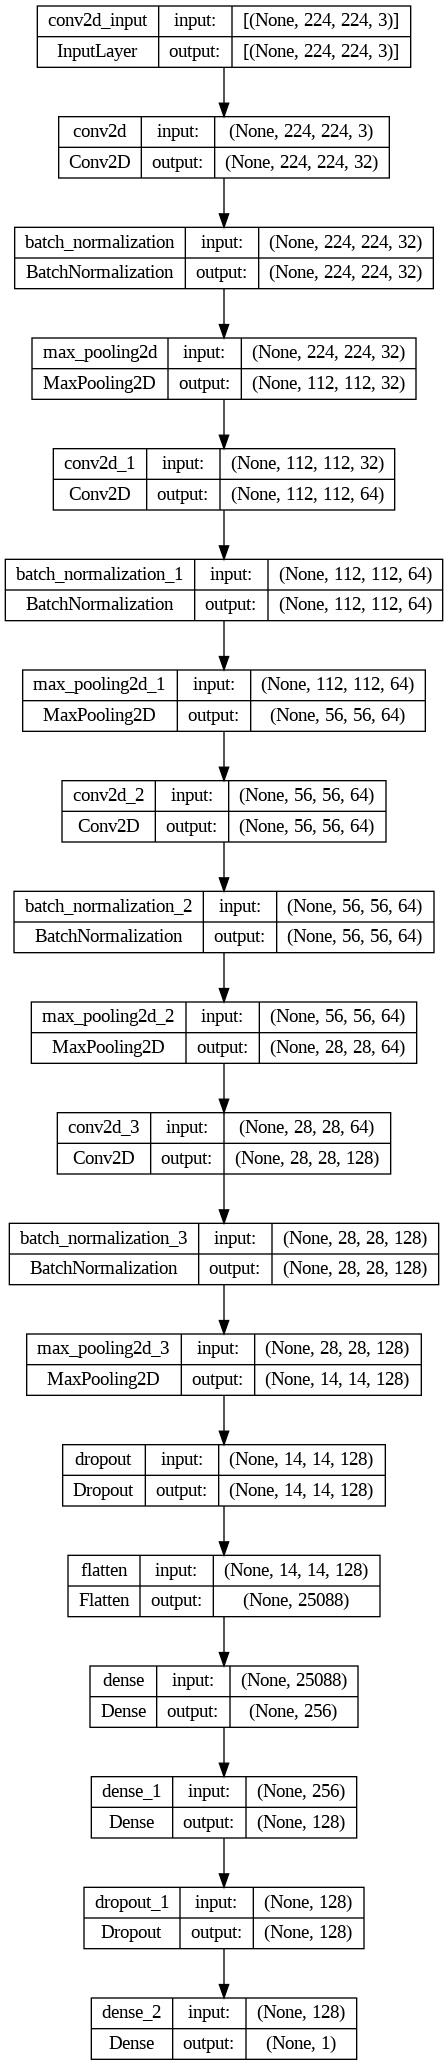

In [7]:
# plot model architecture diagram for ResNet50V2
plot_model(conv_cnn_model, to_file='base_cnn_model.png', show_shapes=True, show_layer_names=True)
display(Image.open('base_cnn_model.png'))

**3.2 & 3.3 Compile Model with Optimizer and Set Callbacks**

In [ ]:
#--------------------------------------------------------------------------------------#
# 3.2 Compile Model and Obtain Summary
#--------------------------------------------------------------------------------------#
learn_rate = init_learn_rate  # which is equivalent to 0.01
# compile model
conv_cnn_model.compile(loss='binary_crossentropy'
                      , optimizer = keras.optimizers.Adam(learning_rate=learn_rate)
                      , metrics='binary_accuracy')
print('Step: Model Compilation complete.')
#--------------------------------------------------------------------------------------#
# 3.3 Setting CNN Callbacks List
#--------------------------------------------------------------------------------------#
conv_cnn_model_checkpoint = "conv_cnn_best_model_v1.h5"            # provide checkpoint filename
cnn_callbacks = set_callbacks(conv_cnn_model_checkpoint)           # call custom function to define callbacks
print('Step: Conv CNN - Setting Callbacks and Checkpoints complete.')

Step: Model Compilation complete.
Step: Conv CNN - Setting Callbacks and Checkpoints complete.


**3.3 Setting Callbacks**

**EarlyStopping** - prevent overfitting by stopping the training process when the validation loss fails to improve for a certain number of epochs (consecutive training iterations).

**ReduceLROnPlateau** - addresses the situation where the training process gets stuck in a local minimum (not the global minimum) and validation loss stops decreasing.

**3.4 Model Training Phase**

In [ ]:
#--------------------------------------------------------------------------------------#
# 3.4 Model Training
#--------------------------------------------------------------------------------------#
#%%time
train_start = time.time() # get start time

# train model
cnn_history = conv_cnn_model.fit(training_ds,
                                  validation_data=validation_ds,
                                  epochs=30,
                                  verbose=1,
                                  callbacks=cnn_callbacks,
                                  class_weight=class_weights
                                  )
#calculate training time
cnn_train_time = time.time() - train_start
print("Training time:", cnn_train_time)
print('Step: Model Training/Fitting complete.')

Epoch 1/30
129/129 [==============================] - 22s 146ms/step - loss: 25.7671 - binary_accuracy: 0.8663 - val_loss: 4.3903 - val_binary_accuracy: 0.8692 - lr: 0.0100
Epoch 2/30
129/129 [==============================] - 19s 145ms/step - loss: 3.9896 - binary_accuracy: 0.9332 - val_loss: 4.2456 - val_binary_accuracy: 0.9215 - lr: 0.0100
Epoch 3/30
129/129 [==============================] - 19s 146ms/step - loss: 4.0243 - binary_accuracy: 0.9427 - val_loss: 4.1394 - val_binary_accuracy: 0.9374 - lr: 0.0100
Epoch 4/30
129/129 [==============================] - 19s 146ms/step - loss: 3.9111 - binary_accuracy: 0.9490 - val_loss: 3.9741 - val_binary_accuracy: 0.9420 - lr: 0.0100
Epoch 5/30
129/129 [==============================] - 19s 146ms/step - loss: 3.9235 - binary_accuracy: 0.9512 - val_loss: 4.0672 - val_binary_accuracy: 0.9067 - lr: 0.0100
Epoch 6/30
128/129 [============================>.] - ETA: 0s - loss: 3.8688 - binary_accuracy: 0.9536
Epoch 6: ReduceLROnPlateau reducing 

In [1]:
# plot accuracy and loss evolution for Conv CNN model
plot_history(cnn_history, conv_cnn_model, 'Conv CNN')

In [ ]:
### Load Weights
conv_cnn_model.load_weights(conv_cnn_model_checkpoint)
print('Step: Loading Weights complete.')

# clear tf session
tf.keras.backend.clear_session()

#saving model
conv_cnn_model.save('conv_model.keras')

# Load model
cnn_model_path= 'conv_model.keras'
loaded_cnn_model_1 = tf.keras.models.load_model(cnn_model_path)

print('Step: Saving and Loading Model complete.')

Step: Loading Weights complete.
Step: Saving and Loading Model complete.


In [ ]:
# get model accuracy and loss
cnn_loss_metrics_df = evaluate_loss_accuracy(conv_cnn_model, 'Conv CNN')
print('Step: Evaluate Model Accuracy and Loss complete.')

129/129 - 2s - loss: 0.0897 - binary_accuracy: 0.9780 - 2s/epoch - 17ms/step
28/28 - 1s - loss: 0.1359 - binary_accuracy: 0.9659 - 555ms/epoch - 20ms/step
28/28 - 1s - loss: 0.1327 - binary_accuracy: 0.9613 - 551ms/epoch - 20ms/step

Conv CNN: Loss and Accuracy Values 
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
      Model  Train Loss  Val Loss  Test Loss  Train Accuracy  Val Accuracy  \
0  Conv CNN    0.089696  0.135877     0.1327        0.978043       0.96587   

   Test Accuracy  
0       0.961276  


Step: Evaluate Model Accuracy and Loss complete.


**3.5 Predictions on Test Data**

In [ ]:
#--------------------------------------------------------------------------------------#
# 3.5 Model Predictions on Test Data
#--------------------------------------------------------------------------------------#
# Call Function to Predict on Test Data and Generate Classification Report
class_report_v1, y_actual, y_predicted = get_model_predictions(conv_cnn_model, testing_ds)
print("Base CNN Model - Classification Report (Test) \n=================================================================")
print(class_report_v1)

Base CNN Model - Classification Report (Test) 
              precision    recall  f1-score   support

      normal       0.95      0.91      0.93       237
   pneumonia       0.97      0.98      0.97       641

    accuracy                           0.96       878
   macro avg       0.96      0.94      0.95       878
weighted avg       0.96      0.96      0.96       878



**3.6 Performance Evaluation on Base CNN Model**

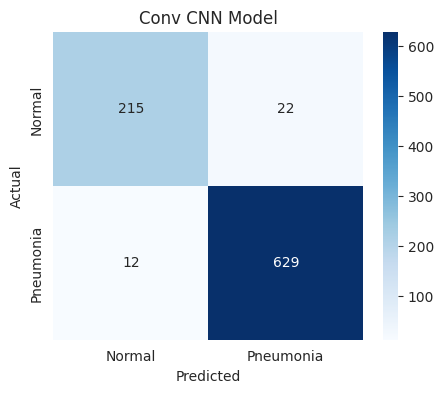

---------------------------------------------------------------------------------
Pneumonia cases incorrectly classified as Pneumonia, its actually Normal: 22
Normal cases incorrectly classified as Normal, its actually Pneumonia: 12

---------------------------------------------------------------------------------
Conventional CNN Model Performance:

      Model  Accuracy  Precision  Recall  F1-Score  FP  FN   TP   TN
0  Conv CNN     96.13      96.62   98.13     97.37  22  12  629  215

---------------------------------------------------------------------------------


In [ ]:
#--------------------------------------------------------------------------------------#
# 3.6 Performance Evaluation
#--------------------------------------------------------------------------------------#
# Get Metrics for CNN Base Model
cnn_performance_df = evaluate_model_performance(conv_cnn_model, y_actual, y_predicted, 'Conv CNN')
print('Conventional CNN Model Performance:\n')
print(cnn_performance_df)
print('\n---------------------------------------------------------------------------------')

AUC-ROC: 0.9442261234753189


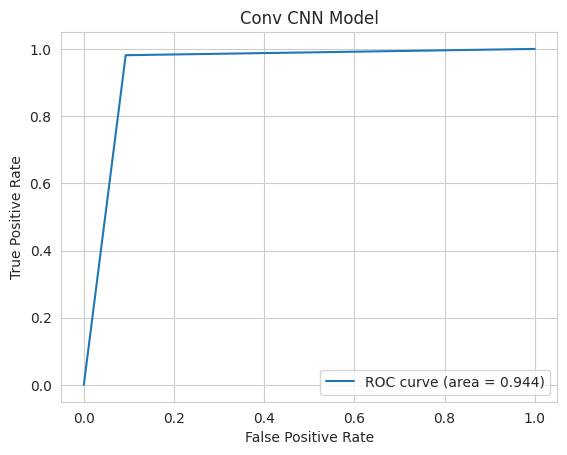

In [ ]:
# CALL function to plot auc-roc curve
cnn_auc = plot_roc_curve(y_actual, y_predicted, 'Conv CNN')

In [ ]:
# Add the AUC column to the DataFrame
cnn_performance_df['AUC'] = cnn_auc
cnn_performance_df['Train Time'] = round(cnn_train_time, 2)
cnn_performance_df

Model  Accuracy  Precision  Recall  F1-Score  FP  FN   TP   TN    AUC  \
0  Conv CNN     96.13      96.62   98.13     97.37  22  12  629  215  0.944   

   Train Time  
0      570.73

# Section 4: Modelling - Pretrained Model (VGG16)

**4.1 Defining the Model Architecture**

In [8]:
#--------------------------------------------------------------------------------------#
# 4.1 Define VGG16 Model Architecture
#--------------------------------------------------------------------------------------#
# clear tf session
tf.keras.backend.clear_session()

# Load VGG16, input shape = (224,224,3)
base_pretrained_model = VGG16(weights='imagenet', input_shape=input_shape, include_top=False)

# Build model on top of VGG16
vgg16_cnn_model = tf.keras.Sequential()

# add the vgg16 base model
vgg16_cnn_model.add(base_pretrained_model)
vgg16_cnn_model.add(BatchNormalization())
vgg16_cnn_model.add(Dropout(0.2))
vgg16_cnn_model.add(GlobalAveragePooling2D())

# add flatten and dense layers with l2 regularizer
#vgg16_cnn_model.add(Flatten())
vgg16_cnn_model.add(Dense(256, activation='relu'))
vgg16_cnn_model.add(Dense(128, activation='relu', kernel_regularizer=l1_l2(0.1, 0.1)))
vgg16_cnn_model.add(Dropout(0.2))

#final output layer
vgg16_cnn_model.add(Dense(1, activation='sigmoid'))

# freeze the weights of the layers in base vgg16 model, so that they will not be updated during the training process.
for layer in base_pretrained_model.layers:
    layer.trainable = False

# display model architechture
vgg16_cnn_model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization (Batch  (None, 7, 7, 512)         2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                         

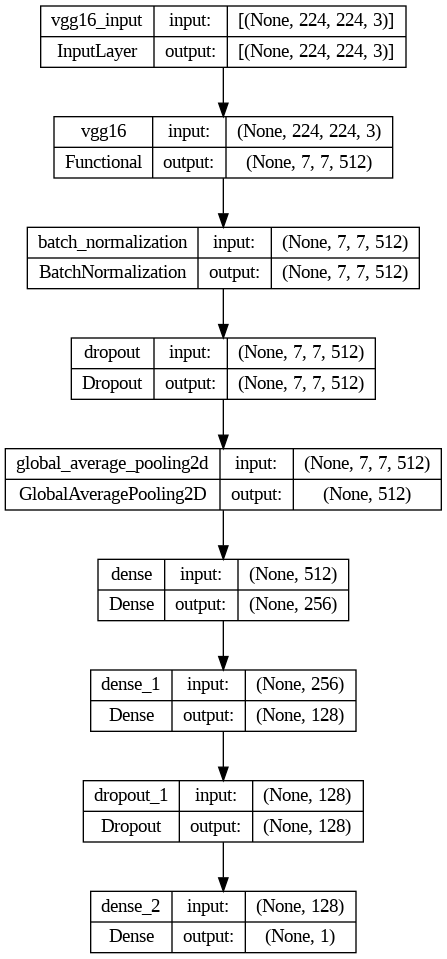

In [9]:
# plot model architecture diagram for VGG16
plot_model(vgg16_cnn_model, to_file='base_vgg16_model.png', show_shapes=True, show_layer_names=True)
display(Image.open('base_vgg16_model.png'))

**4.2 & 4.3 Compile Model with Optimizer and Set Callbacks**

In [ ]:
#--------------------------------------------------------------------------------------#
# 4.2 Compile Model with Optimizer
#--------------------------------------------------------------------------------------#
# set hyperparameter constants
vgg_learn_rate_v1 = init_learn_rate  # which is equivalent to 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=vgg_learn_rate_v1)

# compile model
vgg16_cnn_model.compile(loss='binary_crossentropy', optimizer = optimizer, metrics='binary_accuracy')
print('Step: Pretrained Model Compilation complete.')

#--------------------------------------------------------------------------------------#
# 4.3 Set Callbacks list
#--------------------------------------------------------------------------------------#
vgg16_model_checkpoint = "vgg16_best_model.h5"            # provide checkpoint filename
vgg16_callbacks = set_callbacks(vgg16_model_checkpoint)   # call custom function to define callbacks
print('Step: VGG16 - Setting Callbacks and Checkpoints complete.')

Step: Pretrained Model Compilation complete.
Step: VGG16 - Setting Callbacks and Checkpoints complete.


**4.4 Model Training Phase**

In [ ]:
#--------------------------------------------------------------------------------------#
# 4.4 Training Pretrained Model: VGG16
#--------------------------------------------------------------------------------------#
#%%time
train_start = time.time() # get start time

# train model
vgg16_history = vgg16_cnn_model.fit(training_ds,
                                  validation_data=validation_ds,
                                  epochs=30,
                                  verbose=1,
                                  callbacks=vgg16_callbacks
                                  )

#calculate train times
vgg16_train_time = time.time() - train_start
print("\nTraining time:", vgg16_train_time)

print('Step: Model Training/Fitting complete.')

Epoch 1/30
129/129 [==============================] - 24s 171ms/step - loss: 17.0997 - binary_accuracy: 0.8863 - val_loss: 5.0673 - val_binary_accuracy: 0.7327 - lr: 0.0100
Epoch 2/30
129/129 [==============================] - 23s 176ms/step - loss: 4.4412 - binary_accuracy: 0.9361 - val_loss: 4.2655 - val_binary_accuracy: 0.8953 - lr: 0.0100
Epoch 3/30
129/129 [==============================] - 23s 181ms/step - loss: 4.2201 - binary_accuracy: 0.9429 - val_loss: 4.0667 - val_binary_accuracy: 0.9443 - lr: 0.0100
Epoch 4/30
129/129 [==============================] - 23s 182ms/step - loss: 4.0913 - binary_accuracy: 0.9475 - val_loss: 4.0468 - val_binary_accuracy: 0.9590 - lr: 0.0100
Epoch 5/30
129/129 [==============================] - 25s 190ms/step - loss: 4.0594 - binary_accuracy: 0.9485 - val_loss: 4.1967 - val_binary_accuracy: 0.8714 - lr: 0.0100
Epoch 6/30
129/129 [==============================] - 25s 193ms/step - loss: 3.9894 - binary_accuracy: 0.9546 - val_loss: 3.9687 - val_bina

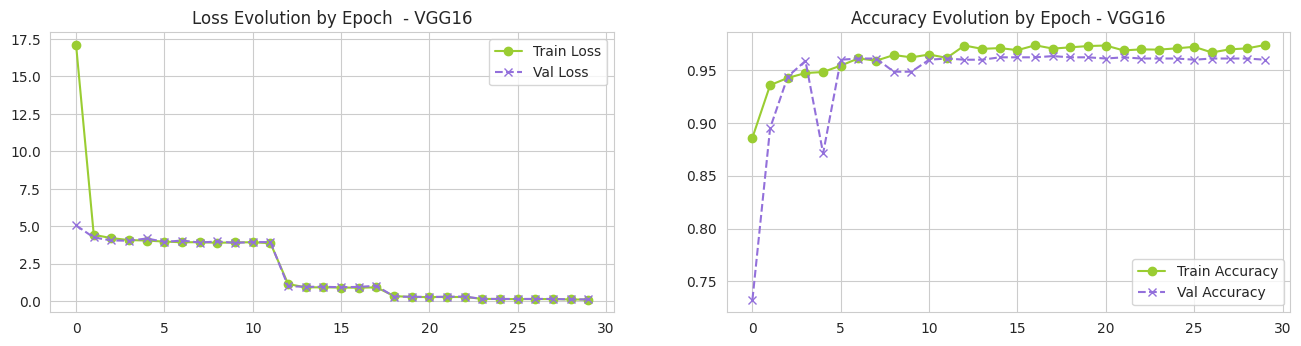

time: 424 ms (started: 2024-06-18 19:11:43 +00:00)


In [ ]:
# plot accuracy and loss evolution for VGG16 model
plot_history(vgg16_history, vgg16_cnn_model, 'VGG16')

In [ ]:
### Load Weights
vgg16_cnn_model.load_weights(vgg16_model_checkpoint)
print('Step: Loading Weights complete.')

# clear tf session
tf.keras.backend.clear_session()

#saving model
vgg16_cnn_model.save('vgg16_model_v1.keras')

# Load model
vgg16_v1_model_path = 'vgg16_model_v1.keras'
loaded_vgg16_model_1 = tf.keras.models.load_model(vgg16_v1_model_path)

print('Step: Saving and Loading Model complete.')

# Evaluate model accuracy and loss (model.evaluate)
vgg16_loss_metrics_df = evaluate_loss_accuracy(vgg16_cnn_model, 'VGG16')
print('Step: Evaluate Model Accuracy and Loss complete.')

Step: Loading Weights complete.
Step: Saving and Loading Model complete.
129/129 - 16s - loss: 0.1102 - binary_accuracy: 0.9761 - 16s/epoch - 123ms/step
28/28 - 3s - loss: 0.1339 - binary_accuracy: 0.9613 - 3s/epoch - 122ms/step
28/28 - 3s - loss: 0.1419 - binary_accuracy: 0.9670 - 3s/epoch - 123ms/step

VGG16: Loss and Accuracy Values 
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
   Model  Train Loss  Val Loss  Test Loss  Train Accuracy  Val Accuracy  \
0  VGG16    0.110244  0.133945   0.141947        0.976092       0.96132   

   Test Accuracy  
0        0.96697  


Step: Evaluate Model Accuracy and Loss complete.
time: 25.7 s (started: 2024-06-18 17:30:03 +00:00)


**4.5 Predictions on Test Data**

In [ ]:
#--------------------------------------------------------------------------------------#
# 4.5 Model Predictions on Test Data
#--------------------------------------------------------------------------------------#
# Call Function to Predict on Test Data and Generate Classification Report
class_report_vgg16_v1, y_actual_vgg16, y_predicted_vgg16 = get_model_predictions(vgg16_cnn_model, testing_ds)
print("VGG16 Pre-trained Model - Classification Report \n=================================================================")
print(class_report_vgg16_v1)

print('\nStep: Predicting on Test Dataset complete.')

VGG16 Pre-trained Model - Classification Report 
              precision    recall  f1-score   support

      normal       0.95      0.93      0.94       237
   pneumonia       0.97      0.98      0.98       641

    accuracy                           0.97       878
   macro avg       0.96      0.95      0.96       878
weighted avg       0.97      0.97      0.97       878


Step: Predicting on Test Dataset complete.
time: 5.93 s (started: 2024-06-18 17:30:35 +00:00)


**4.6 Performance Evaluation on VGG16 Pretrained Model**

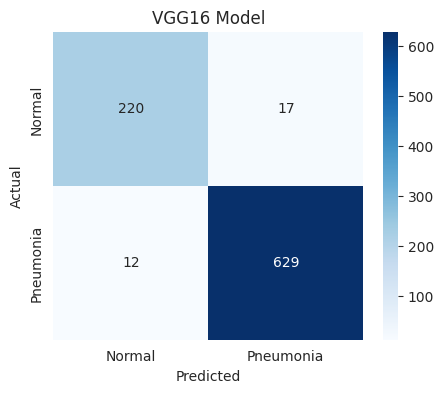

---------------------------------------------------------------------------------
Pneumonia cases incorrectly classified as Pneumonia, its actually Normal: 17
Normal cases incorrectly classified as Normal, its actually Pneumonia: 12

---------------------------------------------------------------------------------
Pretrained Model Performance (VGG16):

   Model  Accuracy  Precision  Recall  F1-Score  FP  FN   TP   TN
0  VGG16      96.7      97.37   98.13     97.75  17  12  629  220

---------------------------------------------------------------------------------
AUC-ROC: 0.9547746466820698


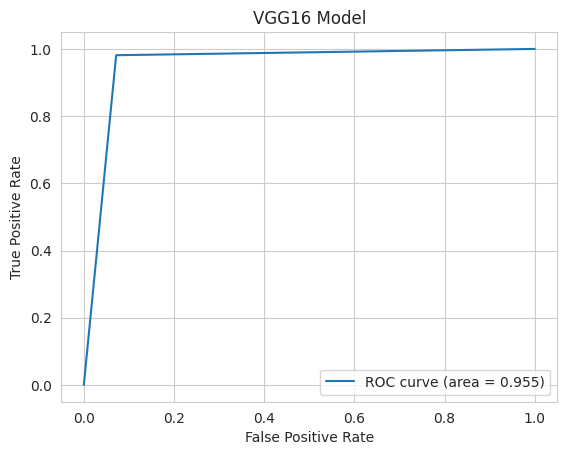

time: 405 ms (started: 2024-06-18 17:30:45 +00:00)


In [ ]:
#--------------------------------------------------------------------------------------#
# 4.6 Performance Evaluation
#--------------------------------------------------------------------------------------#
# Get Metrics for VGG16 Model
vgg16_performance_df = evaluate_model_performance(vgg16_cnn_model, y_actual_vgg16, y_predicted_vgg16, 'VGG16')
print('Pretrained Model Performance (VGG16):\n')
print(vgg16_performance_df)
print('\n---------------------------------------------------------------------------------')

# CALL function to plot auc-roc curve
vgg16_auc = plot_roc_curve(y_actual_vgg16, y_predicted_vgg16, 'VGG16')

In [ ]:
# Add the AUC column to the DataFrame
vgg16_performance_df['AUC'] = vgg16_auc
vgg16_performance_df['Train Time'] = round(vgg16_train_time, 2)
vgg16_performance_df

Model  Accuracy  Precision  Recall  F1-Score  FP  FN   TP   TN    AUC  \
0  VGG16      96.7      97.37   98.13     97.75  17  12  629  220  0.955   

   Train Time  
0      732.51

time: 21.4 ms (started: 2024-06-18 17:30:58 +00:00)


# Section 5: Modelling - Pretrained Model (ResNet50V2)


In [10]:
#--------------------------------------------------------------------------------------#
# 5.1 Define ResNet50V2 Model Architecture
#--------------------------------------------------------------------------------------#Í
def create_model_resnet():

    tf.keras.backend.clear_session()  # clear tf session

    # Load ResNet50V2, input shape = (224,224,3)
    base_resnet_model = ResNet50V2(weights='imagenet', input_shape = input_shape, include_top = False)

    # Note: Freezing all the weights of the layers in base Resnet50 model,
    # so that they will not be updated during the training process.
    for layer in base_resnet_model.layers:
        layer.trainable=False

    # Build model on top of ResNet layer
    resnet_cnn_model = tf.keras.Sequential()

    # Add the ResNet model, dropout, BN and GAP layers
    resnet_cnn_model.add(base_resnet_model)
    resnet_cnn_model.add(BatchNormalization())
    resnet_cnn_model.add(Dropout(0.2))
    resnet_cnn_model.add(GlobalAveragePooling2D())

    # add flatten and dense layers
    #resnet_cnn_model.add(Flatten())
    resnet_cnn_model.add(Dense(256, activation='relu'))
    resnet_cnn_model.add(Dense(128, activation='relu', kernel_regularizer=l1_l2(0.1, 0.1)))
    resnet_cnn_model.add(Dropout(0.2))

    # final output layer
    resnet_cnn_model.add(Dense(1, activation='sigmoid'))

    # display model architechture
    #base_resnet_model.summary()
    resnet_cnn_model.summary()
    return resnet_cnn_model

# call function to create resnet model
resnet_cnn_model = create_model_resnet()

94668760/94668760 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 batch_normalization (Batch  (None, 7, 7, 2048)        8192      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                         

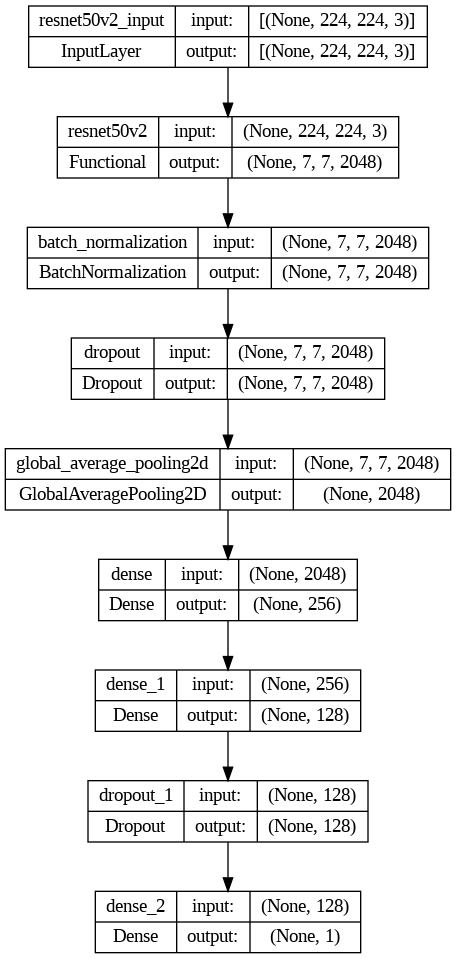

In [11]:
# plot model architecture diagram for ResNet50V2
plot_model(resnet_cnn_model, to_file='base_resnet_model.png', show_shapes=True, show_layer_names=True)
display(Image.open('base_resnet_model.png'))

In [ ]:
#--------------------------------------------------------------------------------------#
# 5.2 Compile Model with Optimizer
#--------------------------------------------------------------------------------------#
# set hyperparameter constants
res_learn_rate_v1 = init_learn_rate  # set as 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=res_learn_rate_v1)

# compile model
resnet_cnn_model.compile(loss='binary_crossentropy', optimizer = optimizer, metrics='binary_accuracy')
print('Step: Pretrained Model Compilation complete.')

#--------------------------------------------------------------------------------------#
# 5.3 Set Callbacks list
#--------------------------------------------------------------------------------------#
resnet_model_checkpoint = "resnet_best_model.h5"            # provide checkpoint filename
res_callbacks = set_callbacks(resnet_model_checkpoint)   # call custom function to define callbacks
print('Step: ResNetV2 - Setting Callbacks and Checkpoints complete.')

Step: Pretrained Model Compilation complete.
Step: ResNetV2 - Setting Callbacks and Checkpoints complete.
time: 13.5 ms (started: 2024-06-18 17:32:57 +00:00)


In [ ]:
#--------------------------------------------------------------------------------------#
# 5.4 Training Pretrained Model: ResNet50V2
#--------------------------------------------------------------------------------------#
#%%time
train_start = time.time() # get start time

# train model
resnet_history = resnet_cnn_model.fit(training_ds,
                                      validation_data=validation_ds,
                                      epochs=30,
                                      verbose=1,
                                      callbacks=res_callbacks)
#calculate train times
resnet_train_time = time.time() - train_start
print("\nTraining time:", resnet_train_time)

print('Step: Model Training/Fitting complete.')

Epoch 1/30
129/129 [==============================] - 18s 112ms/step - loss: 17.0873 - binary_accuracy: 0.9024 - val_loss: 4.6312 - val_binary_accuracy: 0.9545 - lr: 0.0100
Epoch 2/30
129/129 [==============================] - 14s 106ms/step - loss: 4.2138 - binary_accuracy: 0.9495 - val_loss: 4.0162 - val_binary_accuracy: 0.9534 - lr: 0.0100
Epoch 3/30
129/129 [==============================] - 14s 108ms/step - loss: 3.9211 - binary_accuracy: 0.9636 - val_loss: 3.9823 - val_binary_accuracy: 0.9352 - lr: 0.0100
Epoch 4/30
129/129 [==============================] - 14s 105ms/step - loss: 3.9292 - binary_accuracy: 0.9717 - val_loss: 4.1001 - val_binary_accuracy: 0.9613 - lr: 0.0100
Epoch 5/30
129/129 [==============================] - 14s 108ms/step - loss: 4.2244 - binary_accuracy: 0.9712 - val_loss: 3.9308 - val_binary_accuracy: 0.9431 - lr: 0.0100
Epoch 6/30
129/129 [==============================] - 14s 108ms/step - loss: 3.8760 - binary_accuracy: 0.9741 - val_loss: 3.8165 - val_bina

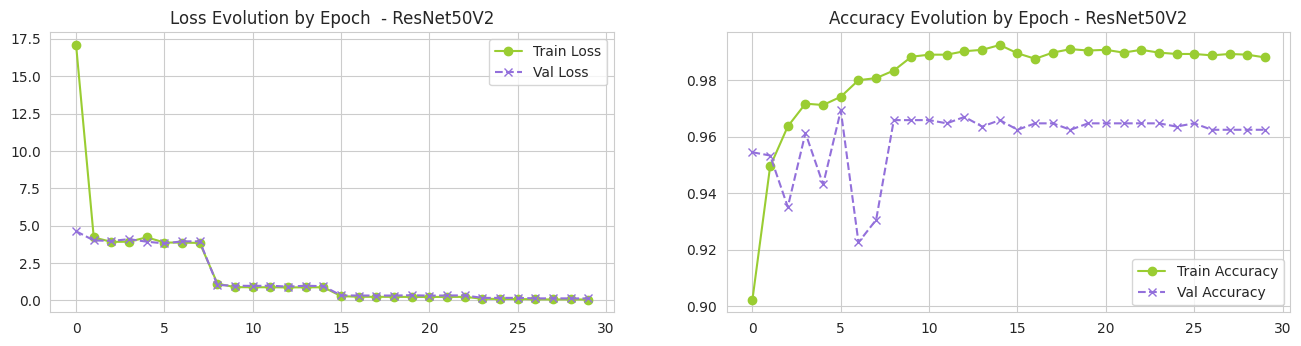

time: 438 ms (started: 2024-06-18 19:11:54 +00:00)


In [ ]:
# plot the accuracy and loss evol
plot_history(resnet_history, resnet_cnn_model, 'ResNet50V2')

In [ ]:
### Load Weights
resnet_cnn_model.load_weights(resnet_model_checkpoint)
print('Step: Loading Weights complete.')

# clear tf session
tf.keras.backend.clear_session()

#saving model
resnet_cnn_model.save('resnet_model_v1.keras')

# Load model
resnet_v1_model_path = 'resnet_model_v1.keras'
loaded_resnet_model_1 = tf.keras.models.load_model(resnet_v1_model_path)
print('Step: Saving and Loading Model complete.')

# Evaluate model accuracy and loss (model.evaluate)
resnet_loss_metrics_df = evaluate_loss_accuracy(resnet_cnn_model, 'ResNet50V2')
print('Step: Evaluate Model Accuracy and Loss complete.')

Step: Loading Weights complete.
Step: Saving and Loading Model complete.
129/129 - 11s - loss: 0.0556 - binary_accuracy: 0.9902 - 11s/epoch - 88ms/step
28/28 - 2s - loss: 0.1336 - binary_accuracy: 0.9625 - 2s/epoch - 86ms/step
28/28 - 3s - loss: 0.1360 - binary_accuracy: 0.9613 - 3s/epoch - 89ms/step

ResNet50V2: Loss and Accuracy Values 
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
        Model  Train Loss  Val Loss  Test Loss  Train Accuracy  Val Accuracy  \
0  ResNet50V2     0.05557  0.133609   0.135991        0.990242      0.962457   

   Test Accuracy  
0       0.961276  


Step: Evaluate Model Accuracy and Loss complete.
time: 30 s (started: 2024-06-18 17:40:50 +00:00)


In [ ]:
#--------------------------------------------------------------------------------------#
# 5.5 Model Predictions on Test Data
#--------------------------------------------------------------------------------------#
# Call Function to Predict on Test Data and Generate Classification Report
class_report_resnet_v1, y_actual_resnet, y_predicted_resnet = get_model_predictions(resnet_cnn_model, testing_ds)
print("ResNet50V2 Pre-trained Model - Classification Report \n=================================================================")
print(class_report_resnet_v1)

print('\nStep: Predicting on Test Dataset complete.')

ResNet50V2 Pre-trained Model - Classification Report 
              precision    recall  f1-score   support

      normal       0.94      0.92      0.93       237
   pneumonia       0.97      0.98      0.97       641

    accuracy                           0.96       878
   macro avg       0.95      0.95      0.95       878
weighted avg       0.96      0.96      0.96       878


Step: Predicting on Test Dataset complete.
time: 6.13 s (started: 2024-06-18 17:41:37 +00:00)


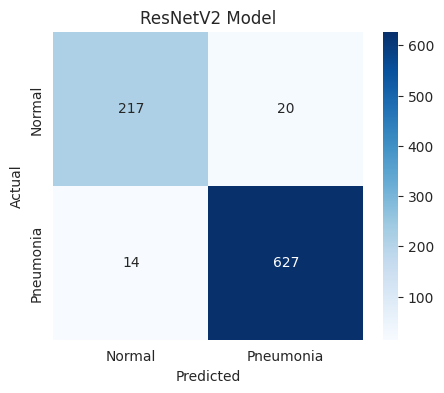

---------------------------------------------------------------------------------
Pneumonia cases incorrectly classified as Pneumonia, its actually Normal: 20
Normal cases incorrectly classified as Normal, its actually Pneumonia: 14

---------------------------------------------------------------------------------
Pretrained Model Performance (ResNetV2):

      Model  Accuracy  Precision  Recall  F1-Score  FP  FN   TP   TN
0  ResNetV2     96.13      96.91   97.82     97.36  20  14  627  217

---------------------------------------------------------------------------------
AUC-ROC: 0.9468854703555232


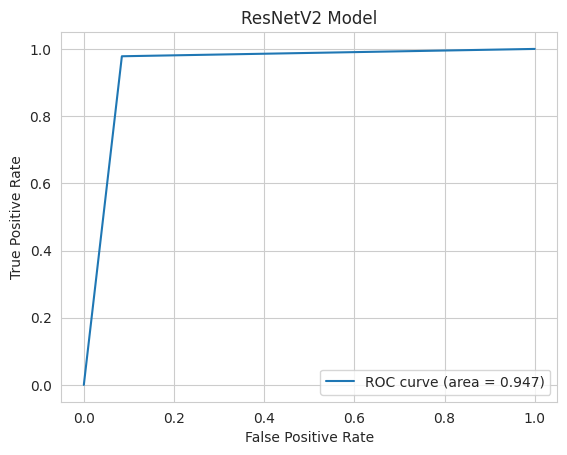

time: 401 ms (started: 2024-06-18 17:41:52 +00:00)


In [ ]:
#--------------------------------------------------------------------------------------#
# 5.6 Performance Evaluation
#--------------------------------------------------------------------------------------#
# Get Metrics for Resnet50V2 Model
resnet_performance_df = evaluate_model_performance(resnet_cnn_model, y_actual_resnet, y_predicted_resnet, 'ResNetV2')
print('Pretrained Model Performance (ResNetV2):\n')
print(resnet_performance_df)
print('\n---------------------------------------------------------------------------------')

# CALL function to plot auc-roc curve
resnet_auc = plot_roc_curve(y_actual_resnet, y_predicted_resnet, 'ResNetV2')

In [ ]:
# Add the AUC column to the DataFrame
resnet_performance_df['AUC'] = resnet_auc
resnet_performance_df['Train Time'] = round(resnet_train_time, 2)
resnet_performance_df

Model  Accuracy  Precision  Recall  F1-Score  FP  FN   TP   TN    AUC  \
0  ResNetV2     96.13      96.91   97.82     97.36  20  14  627  217  0.947   

   Train Time  
0      424.05

time: 23 ms (started: 2024-06-18 17:42:04 +00:00)


# Section 6: Modelling - Pretrained Model (MobileNetV2)

In [12]:
#--------------------------------------------------------------------------------------#
# 6.1 Define MobileNetV2 Model Architecture
#--------------------------------------------------------------------------------------#Í
def create_model_mobilenet():

    tf.keras.backend.clear_session()  # clear tf session

    # Load MobileNetV2, input shape = (224,224,3)
    base_mobilenet_model = MobileNetV2(weights='imagenet', input_shape = input_shape, include_top = False)

    # Note: Freezing all the weights of the layers in base model,
    # so that they will not be updated during the training process.
    for layer in base_mobilenet_model.layers:
        layer.trainable=False

    # Build model on top of MobileNet layer
    mobilenet_cnn_model = tf.keras.Sequential()

    # Add the MobileNet model, dropout, BN and GAP layers
    mobilenet_cnn_model.add(base_mobilenet_model)
    mobilenet_cnn_model.add(BatchNormalization())
    mobilenet_cnn_model.add(Dropout(0.2))
    mobilenet_cnn_model.add(GlobalAveragePooling2D())

    # add flatten and dense layers
    #mobilenet_cnn_model.add(Flatten())
    mobilenet_cnn_model.add(Dense(256, activation='relu'))
    mobilenet_cnn_model.add(Dense(128, activation='relu', kernel_regularizer=l1_l2(0.1, 0.1)))
    mobilenet_cnn_model.add(Dropout(0.2))

    # final output layer
    mobilenet_cnn_model.add(Dense(1, activation='sigmoid'))

    # display model architechture
    #base_mobilenet_model.summary()
    mobilenet_cnn_model.summary()
    return mobilenet_cnn_model

# call function to create resnet model
mobilenet_cnn_model = create_model_mobilenet()

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 1280)        5120      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 7, 7, 1280)        0         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               3279

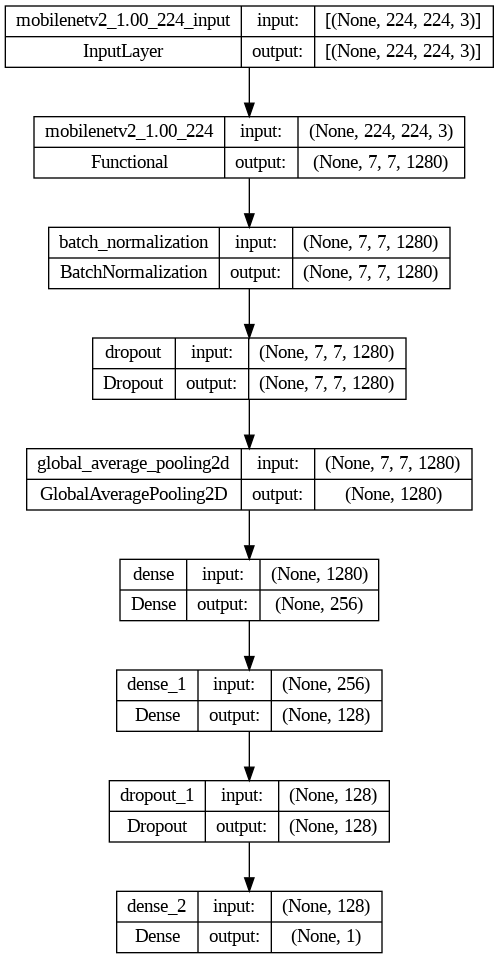

In [13]:
# plot model architecture diagram for ResNet50V2
plot_model(mobilenet_cnn_model, to_file='base_mobilenet_model.png', show_shapes=True, show_layer_names=True)
display(Image.open('base_mobilenet_model.png'))

In [ ]:
#--------------------------------------------------------------------------------------#
# 6.2 Compile Model with Optimizer
#--------------------------------------------------------------------------------------#
# set hyperparameter constants
mobilenet_learn_rate_v1 = init_learn_rate  # set as 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=mobilenet_learn_rate_v1)

# compile model
mobilenet_cnn_model.compile(loss='binary_crossentropy', optimizer = optimizer, metrics='binary_accuracy')
print('Step: Pretrained Model Compilation complete.')

#--------------------------------------------------------------------------------------#
# 6.3 Set Callbacks list
#--------------------------------------------------------------------------------------#
mobilenet_model_checkpoint = "mobilenet_best_model.h5"            # provide checkpoint filename
mobile_callbacks = set_callbacks(mobilenet_model_checkpoint)   # call custom function to define callbacks
print('Step: MobileNetV2 - Setting Callbacks and Checkpoints complete.')

Step: Pretrained Model Compilation complete.
Step: MobileNetV2 - Setting Callbacks and Checkpoints complete.
time: 14.9 ms (started: 2024-06-18 17:44:17 +00:00)


In [ ]:
#--------------------------------------------------------------------------------------#
# 6.4 Training Pretrained Model: MobileNetV2
#--------------------------------------------------------------------------------------#
train_start = time.time() # get start time

# train model
mobilenet_history = mobilenet_cnn_model.fit(training_ds,
                                            validation_data=validation_ds,
                                            epochs=30,
                                            callbacks=mobile_callbacks,
                                            verbose=1)
#calculate train times
mobilenet_train_time = time.time() - train_start
print("\nTraining time:", mobilenet_train_time)
print('Step: Model Training/Fitting complete.')

Epoch 1/30
129/129 [==============================] - 10s 56ms/step - loss: 17.3756 - binary_accuracy: 0.9044 - val_loss: 5.8778 - val_binary_accuracy: 0.8578 - lr: 0.0100
Epoch 2/30
129/129 [==============================] - 6s 48ms/step - loss: 4.8809 - binary_accuracy: 0.9356 - val_loss: 4.5000 - val_binary_accuracy: 0.9545 - lr: 0.0100
Epoch 3/30
129/129 [==============================] - 6s 48ms/step - loss: 3.9612 - binary_accuracy: 0.9554 - val_loss: 4.0843 - val_binary_accuracy: 0.9625 - lr: 0.0100
Epoch 4/30
129/129 [==============================] - 6s 48ms/step - loss: 3.8769 - binary_accuracy: 0.9639 - val_loss: 4.0788 - val_binary_accuracy: 0.9420 - lr: 0.0100
Epoch 5/30
129/129 [==============================] - 6s 47ms/step - loss: 3.8871 - binary_accuracy: 0.9666 - val_loss: 4.5459 - val_binary_accuracy: 0.9568 - lr: 0.0100
Epoch 6/30
129/129 [==============================] - 6s 49ms/step - loss: 3.9048 - binary_accuracy: 0.9732 - val_loss: 3.9176 - val_binary_accuracy

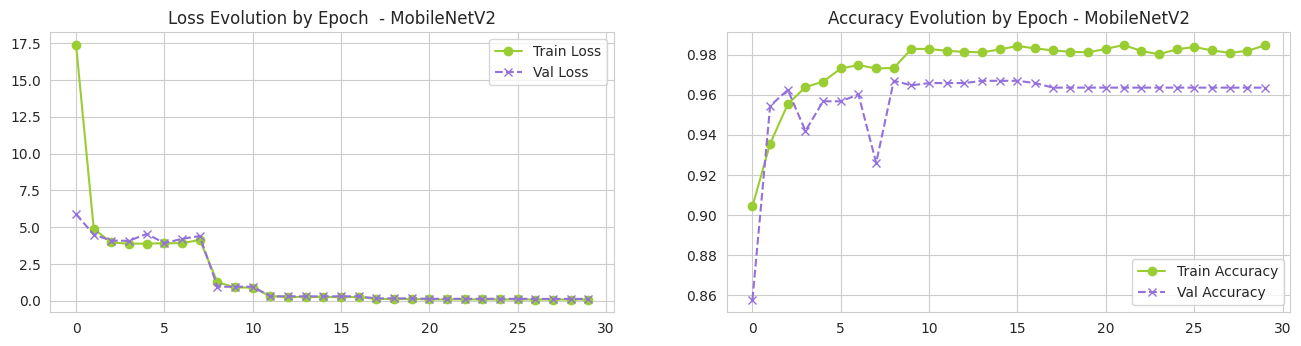

time: 444 ms (started: 2024-06-18 19:12:04 +00:00)


In [ ]:
# plot the accuracy and loss evol
plot_history(mobilenet_history, mobilenet_cnn_model, 'MobileNetV2')

In [ ]:
### Load Weights
mobilenet_cnn_model.load_weights(mobilenet_model_checkpoint)
print('Step: Loading Weights complete.')

# clear tf session
tf.keras.backend.clear_session()

#saving model
mobilenet_cnn_model.save('mobilenet_model_v1.keras')

# Load model
mobilenet_v1_model_path = 'mobilenet_model_v1.keras'
loaded_mobilenet_model_1 = tf.keras.models.load_model(mobilenet_v1_model_path)
print('Step: Saving and Loading Model complete.')

# Evaluate model accuracy and loss (model.evaluate)
mobilenet_loss_metrics_df = evaluate_loss_accuracy(mobilenet_cnn_model, 'MobileNetV2')
print('Step: Evaluate Model Accuracy and Loss complete.')

Step: Loading Weights complete.
Step: Saving and Loading Model complete.
129/129 - 5s - loss: 0.0775 - binary_accuracy: 0.9829 - 5s/epoch - 39ms/step
28/28 - 1s - loss: 0.1290 - binary_accuracy: 0.9636 - 1s/epoch - 38ms/step
28/28 - 1s - loss: 0.1360 - binary_accuracy: 0.9601 - 1s/epoch - 40ms/step

MobileNetV2: Loss and Accuracy Values 
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
         Model  Train Loss  Val Loss  Test Loss  Train Accuracy  Val Accuracy  \
0  MobileNetV2    0.077503  0.129001   0.135991        0.982923      0.963595   

   Test Accuracy  
0       0.960137  


Step: Evaluate Model Accuracy and Loss complete.
time: 11.8 s (started: 2024-06-18 17:47:59 +00:00)


In [ ]:
#--------------------------------------------------------------------------------------#
# 6.5 Model Predictions on Test Data
#--------------------------------------------------------------------------------------#
# Call Function to Predict on Test Data and Generate Classification Report
class_report_mobilenet_v1, y_actual_mobilenet, y_predicted_mobilenet = get_model_predictions(mobilenet_cnn_model, testing_ds)
print("ResNet50V2 Pre-trained Model - Classification Report \n=================================================================")
print(class_report_mobilenet_v1)

print('\nStep: Predicting on Test Dataset complete.')

ResNet50V2 Pre-trained Model - Classification Report 
              precision    recall  f1-score   support

      normal       0.94      0.92      0.93       237
   pneumonia       0.97      0.98      0.97       641

    accuracy                           0.96       878
   macro avg       0.95      0.95      0.95       878
weighted avg       0.96      0.96      0.96       878


Step: Predicting on Test Dataset complete.
time: 4.22 s (started: 2024-06-18 17:48:11 +00:00)


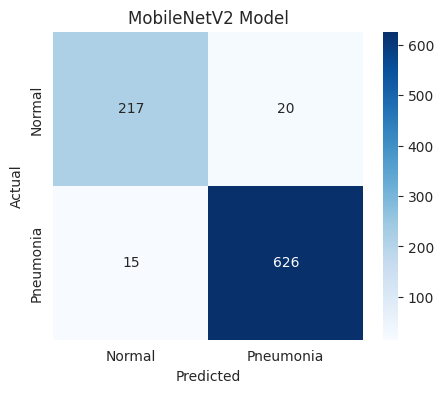

---------------------------------------------------------------------------------
Pneumonia cases incorrectly classified as Pneumonia, its actually Normal: 20
Normal cases incorrectly classified as Normal, its actually Pneumonia: 15

---------------------------------------------------------------------------------
Pretrained Model Performance (MobileNetV2):

         Model  Accuracy  Precision  Recall  F1-Score  FP  FN   TP   TN
0  MobileNetV2     96.01       96.9   97.66     97.28  20  15  626  217

---------------------------------------------------------------------------------
AUC-ROC: 0.9547746466820698


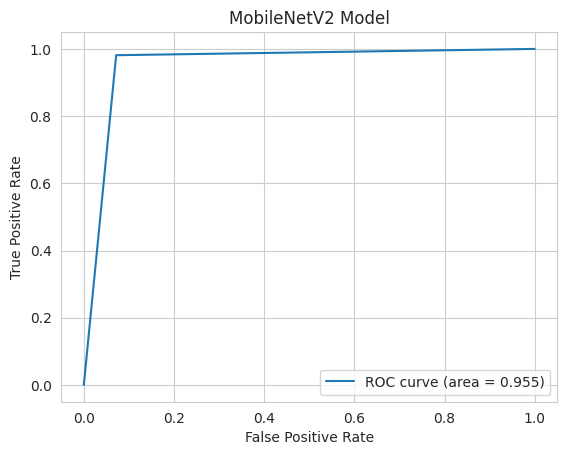

time: 395 ms (started: 2024-06-18 17:48:20 +00:00)


In [ ]:
#--------------------------------------------------------------------------------------#
# 6.6 Performance Evaluation
#--------------------------------------------------------------------------------------#
# Get Metrics for MobileNetV2 Model
mobilenet_performance_df = evaluate_model_performance(mobilenet_cnn_model, y_actual_mobilenet, y_predicted_mobilenet, 'MobileNetV2')
print('Pretrained Model Performance (MobileNetV2):\n')
print(mobilenet_performance_df)
print('\n---------------------------------------------------------------------------------')

# CALL function to plot auc-roc curve
mobilenet_auc = plot_roc_curve(y_actual_vgg16, y_predicted_vgg16, 'MobileNetV2')

In [ ]:
# Add the AUC column to the DataFrame
mobilenet_performance_df['AUC'] = mobilenet_auc
mobilenet_performance_df['Train Time'] = round(mobilenet_train_time, 2)
mobilenet_performance_df

Model  Accuracy  Precision  Recall  F1-Score  FP  FN   TP   TN  \
0  MobileNetV2     96.01       96.9   97.66     97.28  20  15  626  217   

     AUC  Train Time  
0  0.955      191.69

time: 22.3 ms (started: 2024-06-18 17:48:31 +00:00)


# Section 7-1: Hyperparameter Tuning on VGG16


In [15]:
#--------------------------------------------------------------------------------------#
# Section 7-1: Hyperparameter Tuning on VGG16
#--------------------------------------------------------------------------------------#
# Changes to Model:
# 1. added another fully connected layer, with 512 units
# 2. changed output dropout from 0.2 to 0.4
# 3. decreased learning rate from 0.01 to 0.0001, added clipnorm=0.6 to clip gradients
#--------------------------------------------------------------------------------------#
tf.keras.backend.clear_session()
# Load VGG16, input shape = (224,224,3)
base_pretrained_model = VGG16(weights='imagenet', input_shape=input_shape, include_top=False)

# Build model on top of VGG16
vgg16_model_V2 = tf.keras.Sequential()

# add the vgg16 base model, Dropout, BN and GAP layers
vgg16_model_V2.add(base_pretrained_model)
vgg16_model_V2.add(BatchNormalization())
vgg16_model_V2.add(Dropout(0.2))
vgg16_model_V2.add(GlobalAveragePooling2D())

# add flatten and dense layers with l2 regularizer
vgg16_model_V2.add(Dense(512, activation='relu'))
vgg16_model_V2.add(Dense(256, activation='relu'))
vgg16_model_V2.add(Dense(128, activation='relu', kernel_regularizer=l1_l2(0.1, 0.1)))
vgg16_model_V2.add(Dropout(0.4))

#final output layer
vgg16_model_V2.add(Dense(1, activation='sigmoid'))

# freeze the weights of the layers in base vgg16 model, so that they will not be updated during the training process.
for layer in base_pretrained_model.layers:
    layer.trainable = False

# display model architechture
vgg16_model_V2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization (Batch  (None, 7, 7, 512)         2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 256)               1

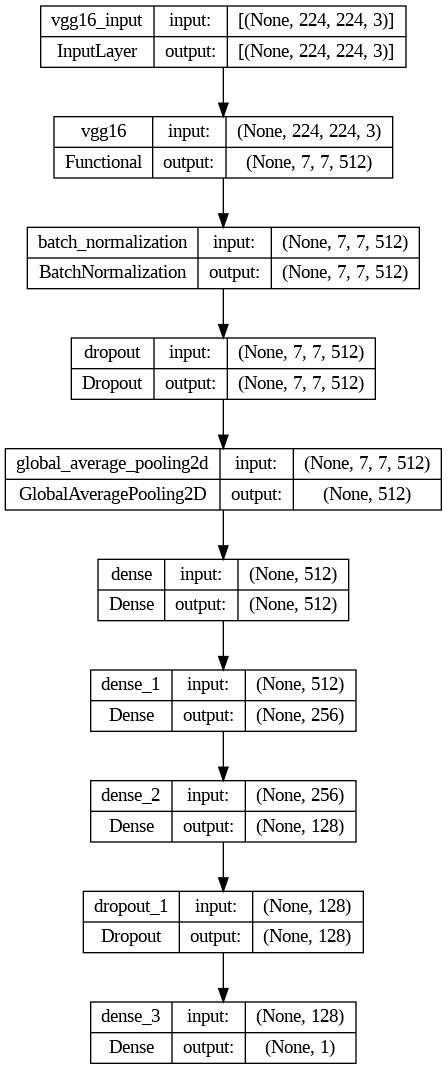

In [16]:
# plot model architecture diagram
plot_model(vgg16_model_V2, to_file='tuned_vgg16_model.png', show_shapes=True, show_layer_names=True)
display(Image.open('tuned_vgg16_model.png'))

In [ ]:
# set hyperparameter constants
new_learning_rate = 0.0001  # Set new learning rate
new_optimizer = tf.keras.optimizers.Adam(learning_rate=new_learning_rate, clipnorm=0.6) # added clipnorm

# Recompile the model with the new optimizer
vgg16_model_V2.compile(loss='binary_crossentropy', optimizer = new_optimizer, metrics='binary_accuracy')
print('Step: Pretrained Model Compilation complete.')

#--------------------------------------------------------------------------------------#
# Set Callbacks list
#--------------------------------------------------------------------------------------#
vgg16v2_model_checkpoint = "vgg16v2_best_model1.h5"            # provide checkpoint filename
vgg16v2_callbacks = set_callbacks(vgg16v2_model_checkpoint)   # call custom function to define callbacks
print('Step: VGG16_V2 - Setting Callbacks and Checkpoints complete.')


Step: Pretrained Model Compilation complete.
Step: VGG16_V2 - Setting Callbacks and Checkpoints complete.
time: 13 ms (started: 2024-06-18 17:56:05 +00:00)


In [ ]:
#--------------------------------------------------------------------------------------#
# Training Pretrained Model: VGG16_V2
#--------------------------------------------------------------------------------------#
train_start = time.time() # get start time
# train model
vgg16v2_history = vgg16_model_V2.fit(training_ds,
                                  validation_data=validation_ds,
                                  epochs=30,
                                  verbose=1,
                                  callbacks=vgg16v2_callbacks
                                  )
vgg16v2_train_time = time.time() - train_start  #calculate train times
print("\nTraining time:", vgg16v2_train_time)
print('Step: Model Training/Fitting complete.')

Epoch 1/30
129/129 [==============================] - 24s 174ms/step - loss: 199.6343 - binary_accuracy: 0.8744 - val_loss: 177.3281 - val_binary_accuracy: 0.7691 - lr: 1.0000e-04
Epoch 2/30
129/129 [==============================] - 22s 174ms/step - loss: 157.3046 - binary_accuracy: 0.9334 - val_loss: 137.7950 - val_binary_accuracy: 0.9295 - lr: 1.0000e-04
Epoch 3/30
129/129 [==============================] - 23s 181ms/step - loss: 120.4994 - binary_accuracy: 0.9461 - val_loss: 103.6283 - val_binary_accuracy: 0.9511 - lr: 1.0000e-04
Epoch 4/30
129/129 [==============================] - 25s 192ms/step - loss: 88.9032 - binary_accuracy: 0.9517 - val_loss: 74.6173 - val_binary_accuracy: 0.9568 - lr: 1.0000e-04
Epoch 5/30
129/129 [==============================] - 25s 192ms/step - loss: 62.4027 - binary_accuracy: 0.9578 - val_loss: 50.6375 - val_binary_accuracy: 0.9602 - lr: 1.0000e-04
Epoch 6/30
129/129 [==============================] - 25s 190ms/step - loss: 40.8246 - binary_accuracy: 

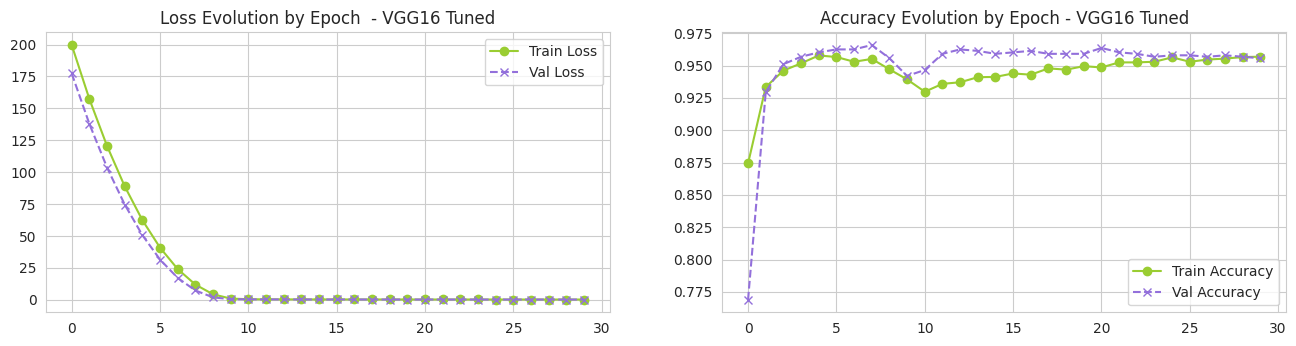

time: 458 ms (started: 2024-06-18 19:12:24 +00:00)


In [ ]:
# plot accuracy and loss evolution for VGG16 model
plot_history(vgg16v2_history, vgg16_model_V2, 'VGG16 Tuned')

In [ ]:
### Load Weights
vgg16_model_V2.load_weights(vgg16v2_model_checkpoint)
print('Step: Loading Weights complete.')

# clear tf session
tf.keras.backend.clear_session()

#saving model
vgg16_model_V2.save('vgg16_model_v1.keras')

# Load model
vgg16_v2_model_path = 'vgg16_model_v1.keras'
loaded_vgg16_model_1 = tf.keras.models.load_model(vgg16_v2_model_path)

print('Step: Saving and Loading Model complete.')

# Evaluate model accuracy and loss (model.evaluate)
vgg16v2_loss_metrics_df = evaluate_loss_accuracy(vgg16_model_V2, 'VGG16 Tuned')
print('Step: Evaluate Model Accuracy and Loss complete.')

Step: Loading Weights complete.
Step: Saving and Loading Model complete.
129/129 - 17s - loss: 0.2040 - binary_accuracy: 0.9634 - 17s/epoch - 135ms/step
28/28 - 4s - loss: 0.2063 - binary_accuracy: 0.9568 - 4s/epoch - 139ms/step
28/28 - 4s - loss: 0.2095 - binary_accuracy: 0.9636 - 4s/epoch - 141ms/step

VGG16 Tuned: Loss and Accuracy Values 
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
         Model  Train Loss  Val Loss  Test Loss  Train Accuracy  Val Accuracy  \
0  VGG16 Tuned    0.203973  0.206293   0.209483        0.963406      0.956769   

   Test Accuracy  
0       0.963554  


Step: Evaluate Model Accuracy and Loss complete.
time: 28.7 s (started: 2024-06-18 18:09:15 +00:00)


In [ ]:
#--------------------------------------------------------------------------------------#
# 4.5 Model Predictions on Test Data
#--------------------------------------------------------------------------------------#
# Call Function to Predict on Test Data and Generate Classification Report
class_report_vgg16_v2, y_actual_vgg16v2, y_predicted_vgg16v2 = get_model_predictions(vgg16_model_V2, testing_ds)
print("VGG16 Pre-trained Model - Classification Report \n=================================================================")
print(class_report_vgg16_v2)

print('\nStep: Predicting on Test Dataset complete.')

VGG16 Pre-trained Model - Classification Report 
              precision    recall  f1-score   support

      normal       0.94      0.92      0.93       237
   pneumonia       0.97      0.98      0.98       641

    accuracy                           0.96       878
   macro avg       0.96      0.95      0.95       878
weighted avg       0.96      0.96      0.96       878


Step: Predicting on Test Dataset complete.
time: 5.63 s (started: 2024-06-18 18:09:52 +00:00)


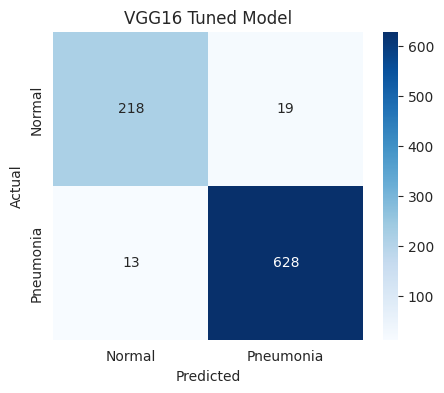

---------------------------------------------------------------------------------
Pneumonia cases incorrectly classified as Pneumonia, its actually Normal: 19
Normal cases incorrectly classified as Normal, its actually Pneumonia: 13

---------------------------------------------------------------------------------
Pretrained Model Performance (VGG16 Tuned):

         Model  Accuracy  Precision  Recall  F1-Score  FP  FN   TP   TN
0  VGG16 Tuned     96.36      97.06   97.97     97.52  19  13  628  218

---------------------------------------------------------------------------------
AUC-ROC: 0.9497752061981214


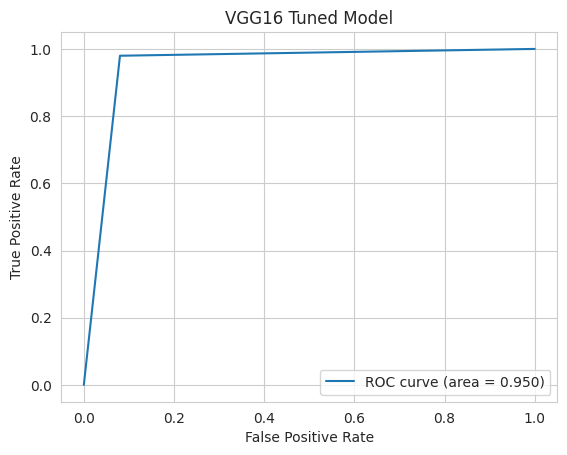

time: 411 ms (started: 2024-06-18 18:10:09 +00:00)


In [ ]:
#--------------------------------------------------------------------------------------#
# Performance Evaluation
#--------------------------------------------------------------------------------------#
# Get Metrics for VGG16v2 Model
vgg16v2_performance_df = evaluate_model_performance(vgg16_model_V2, y_actual_vgg16v2, y_predicted_vgg16v2, 'VGG16 Tuned')
print('Pretrained Model Performance (VGG16 Tuned):\n')
print(vgg16v2_performance_df)
print('\n---------------------------------------------------------------------------------')

# CALL function to plot auc-roc curve
vgg16v2_auc = plot_roc_curve(y_actual_vgg16v2, y_predicted_vgg16v2, 'VGG16 Tuned')

In [ ]:
# Add the AUC column to the DataFrame
vgg16v2_performance_df['AUC'] = vgg16v2_auc
vgg16v2_performance_df['Train Time'] = round(vgg16v2_train_time, 2)
vgg16v2_performance_df

Model  Accuracy  Precision  Recall  F1-Score  FP  FN   TP   TN   AUC  \
0  VGG16 Tuned     96.36      97.06   97.97     97.52  19  13  628  218  0.95   

   Train Time  
0      738.61

time: 21.7 ms (started: 2024-06-18 18:10:25 +00:00)


# Section 7-2: Hyperparameter Tuning on Conv CNN

In [17]:
#--------------------------------------------------------------------------------------#
# Section 7-2: Hyperparameter Tuning on Conv CNN
#--------------------------------------------------------------------------------------#
# Changes to Model:
# 1. added another fully connected layer, with 512 units
# 2. changed output dropout from 0.2 to 0.4
# 3. decreased learning rate from 0.01 to 0.0001, added clipnorm=0.6 to clip gradients
#--------------------------------------------------------------------------------------#
tf.keras.backend.clear_session()

conv_model_V2 = tf.keras.models.Sequential([
    #tf.keras.Input(shape=(224, 224, 3)), # removed to simplify or lessen model layers

    # Hidden Layer 1
    Conv2D(32 , (3,3) , strides = 1 ,padding = 'same', activation = 'relu',input_shape = input_shape),
    BatchNormalization(),
    MaxPool2D((2,2) , strides = 2 , padding = 'same'),

    # Hidden Layer 2
    Conv2D(64 , (3,3) , strides = 1 , padding = 'same', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D((2,2) , strides = 2 , padding = 'same'),

    # Hidden Layer 3
    Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    BatchNormalization(),
    MaxPool2D((2,2) , strides = 2 , padding = 'same'),

    # Hidden Layer 4
    Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    BatchNormalization(),
    MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    Dropout(0.2),

    # Flatten and Fully Connected Layers
    Flatten(),
    Dense(units = 512 , activation = 'relu'),
    Dense(units = 256 , activation = 'relu'),
    Dense(units = 128 , activation = 'relu', kernel_regularizer=l1_l2(0.1, 0.1)), # added second fully connected layer
    Dropout(0.3),
    # Output Layer
    Dense(units = 1 , activation = 'sigmoid')
])

# Load Model Summary
conv_model_V2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 64)      256       
 chNormalization)                                                
                                                        

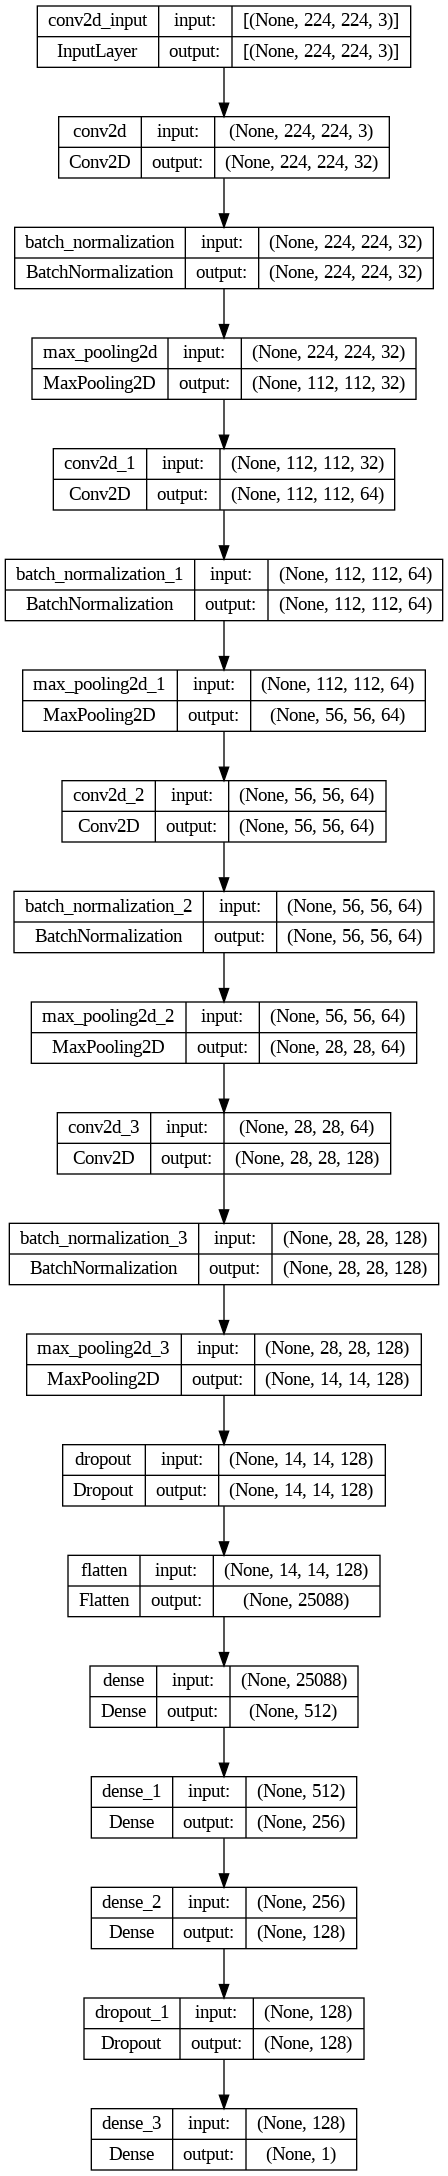

In [18]:
# plot model architecture diagram
plot_model(conv_model_V2, to_file='tuned_conv_model.png', show_shapes=True, show_layer_names=True)
display(Image.open('tuned_conv_model.png'))

In [ ]:
# set hyperparameter constants
new_learning_rate = 0.0001  # Set new learning rate
new_optimizer = tf.keras.optimizers.Adam(learning_rate=new_learning_rate, clipnorm=0.6) # added clipnorm

# Recompile the model with the new optimizer
conv_model_V2.compile(loss='binary_crossentropy', optimizer = new_optimizer, metrics='binary_accuracy')
print('Step: Pretrained Model Compilation complete.')

#--------------------------------------------------------------------------------------#
# Set Callbacks list
#--------------------------------------------------------------------------------------#
convv2_model_checkpoint = "convv2_best_model.h5"            # provide checkpoint filename
convv2_callbacks = set_callbacks(convv2_model_checkpoint)   # call custom function to define callbacks
print('Step: Conv CNN Tuned - Setting Callbacks and Checkpoints complete.')


Step: Pretrained Model Compilation complete.
Step: Conv CNN Tuned - Setting Callbacks and Checkpoints complete.


In [ ]:
#--------------------------------------------------------------------------------------#
# Training Pretrained Model: Conv CNN V2
#--------------------------------------------------------------------------------------#
train_start = time.time() # get start time
# train model
convv2_history = conv_model_V2.fit(training_ds,
                                  validation_data=validation_ds,
                                  epochs=30,
                                  verbose=1,
                                  callbacks=convv2_callbacks
                                  )
convv2_train_time = time.time() - train_start  #calculate train times
print("\nTraining time:", convv2_train_time)
print('Step: Model Training/Fitting complete.')

Epoch 1/30
129/129 [==============================] - 23s 150ms/step - loss: 200.5213 - binary_accuracy: 0.9183 - val_loss: 179.3075 - val_binary_accuracy: 0.7292 - lr: 1.0000e-04
Epoch 2/30
129/129 [==============================] - 19s 150ms/step - loss: 158.5091 - binary_accuracy: 0.9534 - val_loss: 140.1848 - val_binary_accuracy: 0.7292 - lr: 1.0000e-04
Epoch 3/30
129/129 [==============================] - 19s 150ms/step - loss: 121.7360 - binary_accuracy: 0.9661 - val_loss: 105.1620 - val_binary_accuracy: 0.7622 - lr: 1.0000e-04
Epoch 4/30
129/129 [==============================] - 19s 151ms/step - loss: 90.0916 - binary_accuracy: 0.9749 - val_loss: 75.8554 - val_binary_accuracy: 0.9363 - lr: 1.0000e-04
Epoch 5/30
129/129 [==============================] - 20s 151ms/step - loss: 63.4514 - binary_accuracy: 0.9868 - val_loss: 51.6898 - val_binary_accuracy: 0.9556 - lr: 1.0000e-04
Epoch 6/30
129/129 [==============================] - 19s 151ms/step - loss: 41.6993 - binary_accuracy: 

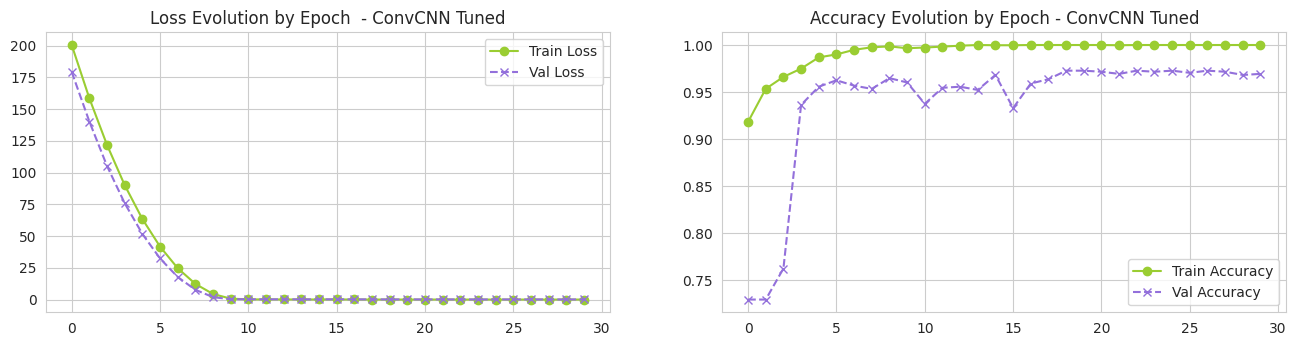

time: 445 ms (started: 2024-06-18 19:12:34 +00:00)


In [ ]:
# plot accuracy and loss evolution for VGG16 model
plot_history(convv2_history, conv_model_V2, 'ConvCNN Tuned')

Step: Loading Weights complete.
Step: Saving and Loading Model complete.
129/129 - 2s - loss: 0.0169 - binary_accuracy: 1.0000 - 2s/epoch - 18ms/step
28/28 - 1s - loss: 0.1033 - binary_accuracy: 0.9693 - 570ms/epoch - 20ms/step
28/28 - 1s - loss: 0.0997 - binary_accuracy: 0.9715 - 583ms/epoch - 21ms/step

ConvCNN Tuned: Loss and Accuracy Values 
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
           Model  Train Loss  Val Loss  Test Loss  Train Accuracy  \
0  ConvCNN Tuned    0.016934  0.103349   0.099705             1.0   

   Val Accuracy  Test Accuracy  
0      0.969283       0.971526  


Step: Evaluate Model Accuracy and Loss complete.
Conv CNN Model - Classification Report 
              precision    recall  f1-score   support

      normal       0.97      0.92      0.95       237
   pneumonia       0.97      0.99      0.98       641

    accuracy                           0.97       878
   macro avg       0.97      0.96      0.96       878
weighted

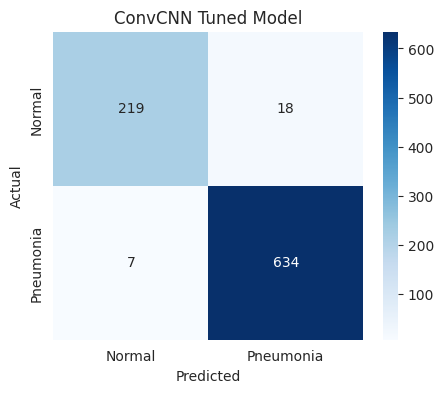

---------------------------------------------------------------------------------
Pneumonia cases incorrectly classified as Pneumonia, its actually Normal: 18
Normal cases incorrectly classified as Normal, its actually Pneumonia: 7

---------------------------------------------------------------------------------
Pretrained Model Performance (ConvCNN Tuned):

           Model  Accuracy  Precision  Recall  F1-Score  FP  FN   TP   TN
0  ConvCNN Tuned     97.15      97.24   98.91     98.07  18   7  634  219

---------------------------------------------------------------------------------
AUC-ROC: 0.9565650980469599


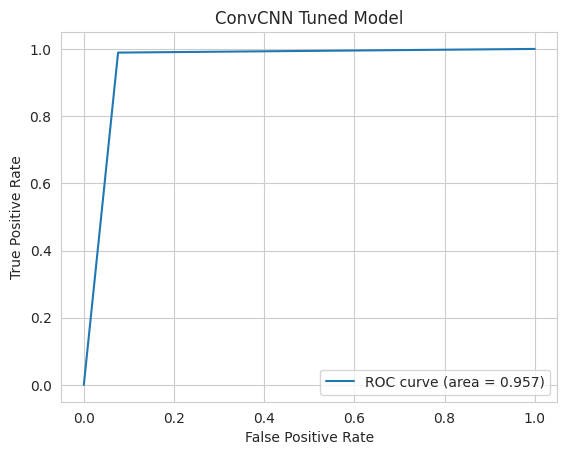

In [ ]:
### Load Weights
conv_model_V2.load_weights(convv2_model_checkpoint)
print('Step: Loading Weights complete.')
tf.keras.backend.clear_session()  # clear tf session

#saving model
conv_model_V2.save('conv_model_v2.keras')
print('Step: Saving and Loading Model complete.')

# Evaluate model accuracy and loss (model.evaluate)
convv2_loss_metrics_df = evaluate_loss_accuracy(conv_model_V2, 'ConvCNN Tuned')
print('Step: Evaluate Model Accuracy and Loss complete.')

#--------------------------------------------------------------------------------------#
# Predict on Test/Unseen Data
#--------------------------------------------------------------------------------------#
# Call Function to Predict on Test Data and Generate Classification Report
class_report_conv_v2, y_actual_convv2, y_predicted_convv2 = get_model_predictions(conv_model_V2, testing_ds)
print("Conv CNN Model - Classification Report \n=================================================================")
print(class_report_conv_v2)
print('\nStep: Predicting on Test Dataset complete.')

#--------------------------------------------------------------------------------------#
# Performance Evaluation
#--------------------------------------------------------------------------------------#
# Get Metrics for ConvCNN Model
convv2_performance_df = evaluate_model_performance(conv_model_V2, y_actual_convv2, y_predicted_convv2, 'ConvCNN Tuned')
print('Pretrained Model Performance (ConvCNN Tuned):\n')
print(convv2_performance_df)
print('\n---------------------------------------------------------------------------------')

# CALL function to plot auc-roc curve
convv2_auc = plot_roc_curve(y_actual_convv2, y_predicted_convv2, 'ConvCNN Tuned')

In [ ]:
# Add the AUC column to the DataFrame
convv2_performance_df['AUC'] = convv2_auc
convv2_performance_df['Train Time'] = round(convv2_train_time, 2)
convv2_performance_df

Model  Accuracy  Precision  Recall  F1-Score  FP  FN   TP   TN  \
0  ConvCNN Tuned     97.15      97.24   98.91     98.07  18   7  634  219   

     AUC  Train Time  
0  0.957      586.97

# Section 7-3: Hyperparameter Tuning on ResNet50V2

In [20]:
#--------------------------------------------------------------------------------------#
# Section 7-3: Hyperparameter Tuning on ResNet50V2
#--------------------------------------------------------------------------------------#
# Changes to Model:
# 1. added another fully connected layer, with 512 units
# 2. changed output dropout from 0.2 to 0.4
# 3. decreased learning rate from 0.01 to 0.0001, added clipnorm=0.8 to clip gradients
tf.keras.backend.clear_session()
# Load ResNet50V2, input shape = (224,224,3)
base_resnet_model = ResNet50V2(weights='imagenet', input_shape = input_shape, include_top = False)

# Note: Freezing all the weights of the layers in base Resnet50 model
for layer in base_resnet_model.layers:
    layer.trainable=False

# Build model on top of ResNet layer
resnet50_model_v2 = tf.keras.Sequential()

# Add the ResNet model, dropout, BN and GAP layers
resnet50_model_v2.add(base_resnet_model)
resnet50_model_v2.add(BatchNormalization())
resnet50_model_v2.add(Dropout(0.2))

# add flatten and dense layers
resnet50_model_v2.add(GlobalAveragePooling2D())
resnet50_model_v2.add(Dense(512, activation='relu'))
resnet50_model_v2.add(Dense(256, activation='relu'))
resnet50_model_v2.add(Dense(128, activation='relu', kernel_regularizer=l1_l2(0.1, 0.1)))
resnet50_model_v2.add(Dropout(0.4))

# final output layer
resnet50_model_v2.add(Dense(1, activation='sigmoid'))
resnet50_model_v2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 batch_normalization (Batch  (None, 7, 7, 2048)        8192      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 256)               1

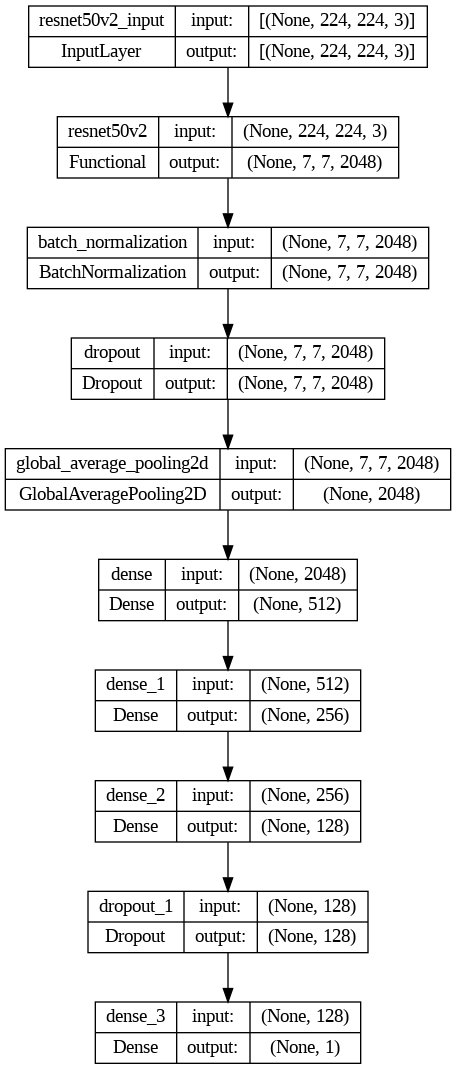

In [21]:
# plot model architecture diagram
plot_model(resnet50_model_v2, to_file='tuned_resnet_model.png', show_shapes=True, show_layer_names=True)
display(Image.open('tuned_resnet_model.png'))

In [ ]:
# set hyperparameter constants
new_learning_rate = 0.0001  # Set your new learning rate here
new_optimizer = tf.keras.optimizers.Adam(learning_rate=new_learning_rate, clipnorm=0.8) # added clipnorm to clip gradients

# Recompile the model with the new optimizer
resnet50_model_v2.compile(loss='binary_crossentropy', optimizer = new_optimizer, metrics='binary_accuracy')
print('Step: Pretrained Model Compilation complete.')

#--------------------------------------------------------------------------------------#
# Set Callbacks list
#--------------------------------------------------------------------------------------#
resv2_model_checkpoint = "resv2_best_model_new.h5"            # provide checkpoint filename
resv2_callbacks = set_callbacks(resv2_model_checkpoint)   # call custom function to define callbacks
print('Step: ResNet Tuned - Setting Callbacks and Checkpoints complete.')

Step: Pretrained Model Compilation complete.
Step: ResNet Tuned - Setting Callbacks and Checkpoints complete.
time: 14.2 ms (started: 2024-06-18 18:17:40 +00:00)


In [ ]:
#--------------------------------------------------------------------------------------#
# Training Pretrained Model: ResNet50V2 Tuned
#--------------------------------------------------------------------------------------#
train_start = time.time() # get start time
# train model
resv2_history = resnet50_model_v2.fit(training_ds,
                                  validation_data=validation_ds,
                                  epochs=30,
                                  verbose=1,
                                  callbacks=resv2_callbacks
                                  )
resv2_train_time = time.time() - train_start  #calculate train times
print("\nTraining time:", resv2_train_time)
print('Step: Model Training/Fitting complete.')

Epoch 1/30
129/129 [==============================] - 19s 112ms/step - loss: 199.6184 - binary_accuracy: 0.8736 - val_loss: 177.1231 - val_binary_accuracy: 0.9488 - lr: 1.0000e-04
Epoch 2/30
129/129 [==============================] - 14s 105ms/step - loss: 157.2012 - binary_accuracy: 0.9427 - val_loss: 137.5658 - val_binary_accuracy: 0.9602 - lr: 1.0000e-04
Epoch 3/30
129/129 [==============================] - 14s 106ms/step - loss: 120.2503 - binary_accuracy: 0.9595 - val_loss: 103.3151 - val_binary_accuracy: 0.9647 - lr: 1.0000e-04
Epoch 4/30
129/129 [==============================] - 14s 107ms/step - loss: 88.5756 - binary_accuracy: 0.9676 - val_loss: 74.2913 - val_binary_accuracy: 0.9670 - lr: 1.0000e-04
Epoch 5/30
129/129 [==============================] - 14s 107ms/step - loss: 62.0777 - binary_accuracy: 0.9729 - val_loss: 50.3668 - val_binary_accuracy: 0.9659 - lr: 1.0000e-04
Epoch 6/30
129/129 [==============================] - 14s 109ms/step - loss: 40.5841 - binary_accuracy: 

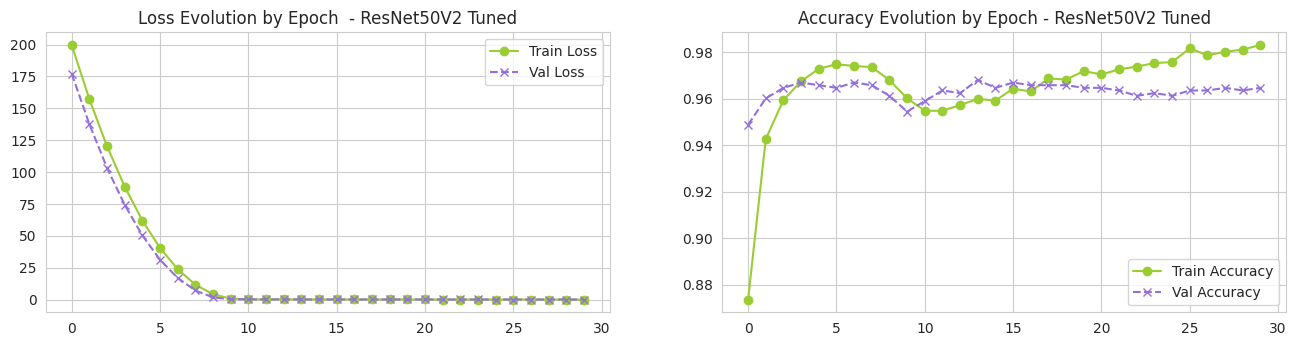

time: 436 ms (started: 2024-06-18 19:13:26 +00:00)


In [ ]:
# plot accuracy and loss evolution for VGG16 model
plot_history(resv2_history, resnet50_model_v2, 'ResNet50V2 Tuned')

Step: Loading Weights complete.
Step: Saving and Loading Model complete.
129/129 - 11s - loss: 0.1417 - binary_accuracy: 0.9880 - 11s/epoch - 86ms/step
28/28 - 2s - loss: 0.1864 - binary_accuracy: 0.9647 - 2s/epoch - 84ms/step
28/28 - 2s - loss: 0.1910 - binary_accuracy: 0.9692 - 2s/epoch - 84ms/step

ResNet50v2 Tuned: Loss and Accuracy Values 
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
              Model  Train Loss  Val Loss  Test Loss  Train Accuracy  \
0  ResNet50v2 Tuned    0.141749  0.186434   0.190955        0.988046   

   Val Accuracy  Test Accuracy  
0      0.964733       0.969248  


Step: Evaluate Model Accuracy and Loss complete.
ResNet50v2 Tuned - Classification Report 
              precision    recall  f1-score   support

      normal       0.96      0.93      0.94       237
   pneumonia       0.97      0.98      0.98       641

    accuracy                           0.97       878
   macro avg       0.97      0.96      0.96       878
w

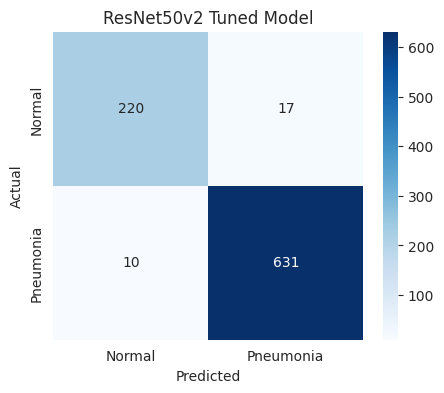

---------------------------------------------------------------------------------
Pneumonia cases incorrectly classified as Pneumonia, its actually Normal: 17
Normal cases incorrectly classified as Normal, its actually Pneumonia: 10

---------------------------------------------------------------------------------
Pretrained Model Performance (ResNet50v2 Tuned):

              Model  Accuracy  Precision  Recall  F1-Score  FP  FN   TP   TN
0  ResNet50v2 Tuned     96.92      97.38   98.44     97.91  17  10  631  220

---------------------------------------------------------------------------------
AUC-ROC: 0.9563347090845659


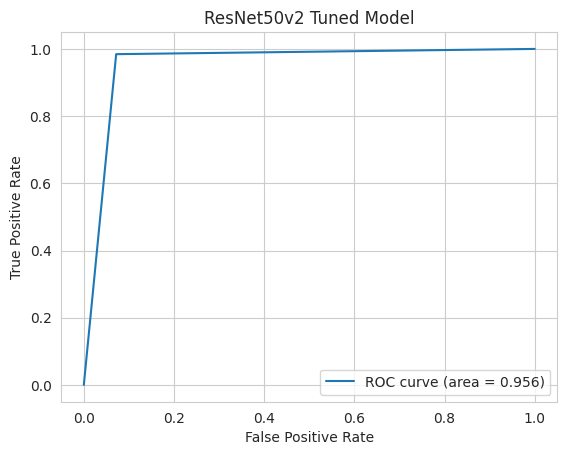

time: 22 s (started: 2024-06-18 18:27:43 +00:00)


In [ ]:
### Load Weights
#resnet50_model_v2.load_weights(resv2_model_checkpoint)
print('Step: Loading Weights complete.')
tf.keras.backend.clear_session()  # clear tf session

#saving model
resnet50_model_v2.save('resnet50_model_v2_new.keras')
print('Step: Saving and Loading Model complete.')

# Evaluate model accuracy and loss (model.evaluate)
resv2_loss_metrics_df = evaluate_loss_accuracy(resnet50_model_v2, 'ResNet50v2 Tuned')
print('Step: Evaluate Model Accuracy and Loss complete.')

#--------------------------------------------------------------------------------------#
# Predict on Test/Unseen Data
#--------------------------------------------------------------------------------------#
# Call Function to Predict on Test Data and Generate Classification Report
class_report_res_v2, y_actual_resv2, y_predicted_resv2 = get_model_predictions(resnet50_model_v2, testing_ds)
print("ResNet50v2 Tuned - Classification Report \n=================================================================")
print(class_report_res_v2)
print('\nStep: Predicting on Test Dataset complete.')

#--------------------------------------------------------------------------------------#
# Performance Evaluation
#--------------------------------------------------------------------------------------#
# Get Metrics for ReNet50v2 Model
resv2_performance_df = evaluate_model_performance(resnet50_model_v2, y_actual_resv2, y_predicted_resv2, 'ResNet50v2 Tuned')
print('Pretrained Model Performance (ResNet50v2 Tuned):\n')
print(resv2_performance_df)
print('\n---------------------------------------------------------------------------------')

# CALL function to plot auc-roc curve
resv2_auc = plot_roc_curve(y_actual_resv2, y_predicted_resv2, 'ResNet50v2 Tuned')

In [ ]:
# Add the AUC column to the DataFrame
resv2_performance_df['AUC'] = resv2_auc
resv2_performance_df['Train Time'] = round(resv2_train_time, 2)
resv2_performance_df

Model  Accuracy  Precision  Recall  F1-Score  FP  FN   TP   TN  \
0  ResNet50v2 Tuned     96.92      97.38   98.44     97.91  17  10  631  220   

     AUC  Train Time  
0  0.956      429.02

time: 22 ms (started: 2024-06-18 18:28:16 +00:00)


# Section 7-4: Hyperparameter Tuning on MobileNetV2

In [22]:
#--------------------------------------------------------------------------------------#
# Section 7-4: Hyperparameter Tuning on MobileNetV2
#--------------------------------------------------------------------------------------#
# Changes to Model:
# 1. added another fully connected layer, with 512 units
# 2. changed output dropout from 0.2 to 0.4
# 3. decreased learning rate from 0.01 to 0.0001, added clipnorm=0.8 to clip gradients
tf.keras.backend.clear_session()  # clear tf session

# Load MobileNetV2, input shape = (224,224,3)
base_mobilenet_model = MobileNetV2(weights='imagenet', input_shape = input_shape, include_top = False)

# Note: Freezing all the weights of the layers in base model
for layer in base_mobilenet_model.layers:
    layer.trainable=False

# Build model on top of MobileNet layer
mobilenet_model_v2 = tf.keras.Sequential()

# Add the MobileNet model, dropout, BN and GAP layers
mobilenet_model_v2.add(base_mobilenet_model)
mobilenet_model_v2.add(BatchNormalization())
mobilenet_model_v2.add(Dropout(0.2))

# add flatten and dense layers
mobilenet_model_v2.add(GlobalAveragePooling2D())
mobilenet_model_v2.add(Dense(512, activation='relu'))
mobilenet_model_v2.add(Dense(256, activation='relu'))
mobilenet_model_v2.add(Dense(128, activation='relu', kernel_regularizer=l1_l2(0.1, 0.1)))
mobilenet_model_v2.add(Dropout(0.4))

# final output layer
mobilenet_model_v2.add(Dense(1, activation='sigmoid'))

# display model architechture
mobilenet_model_v2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 1280)        5120      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 7, 7, 1280)        0         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                        

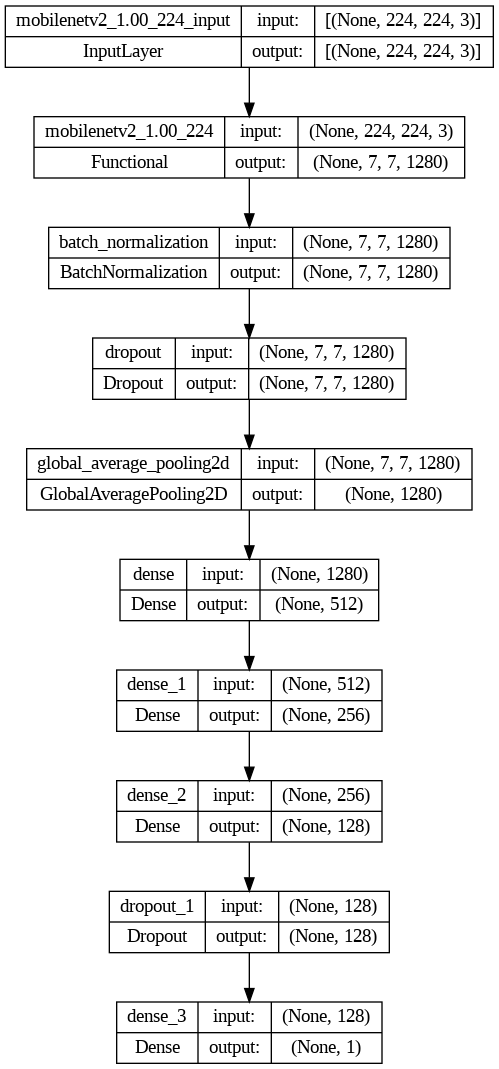

In [23]:
# plot model architecture diagram
plot_model(mobilenet_model_v2, to_file='tuned_mobilenet_model.png', show_shapes=True, show_layer_names=True)
display(Image.open('tuned_mobilenet_model.png'))

In [ ]:
# set hyperparameter constants
new_learning_rate = 0.0001  # Set your new learning rate here
new_optimizer = tf.keras.optimizers.Adam(learning_rate=new_learning_rate, clipnorm=0.8) #from 1.0 to 0.8

# Recompile the model with the new optimizer
mobilenet_model_v2.compile(loss='binary_crossentropy', optimizer = new_optimizer, metrics='binary_accuracy')
print('Step: Pretrained Model Compilation complete.')

#--------------------------------------------------------------------------------------#
# Set Callbacks list
#--------------------------------------------------------------------------------------#
mobilev2_model_checkpoint = "mobilev2_best_model.h5"            # provide checkpoint filename
mobilev2_callbacks = set_callbacks(mobilev2_model_checkpoint)   # call custom function to define callbacks
print('Step: MobiletNetV2 Tuned - Setting Callbacks and Checkpoints complete.')

Step: Pretrained Model Compilation complete.
Step: MobiletNetV2 Tuned - Setting Callbacks and Checkpoints complete.
time: 10.8 ms (started: 2024-06-18 18:32:21 +00:00)


In [ ]:
#--------------------------------------------------------------------------------------#
# Training Pretrained Model: MobileNetV2 Tuned
#--------------------------------------------------------------------------------------#
train_start = time.time() # get start time
# train model
mobv2_history = mobilenet_model_v2.fit(training_ds,
                                  validation_data=validation_ds,
                                  epochs=30,
                                  verbose=1,
                                  callbacks=mobilev2_callbacks
                                  )
mobv2_train_time = time.time() - train_start  #calculate train times
print("\nTraining time:", mobv2_train_time)
print('Step: Model Training/Fitting complete.')

Epoch 1/30
129/129 [==============================] - 11s 56ms/step - loss: 199.8202 - binary_accuracy: 0.8761 - val_loss: 177.3787 - val_binary_accuracy: 0.9317 - lr: 1.0000e-04
Epoch 2/30
129/129 [==============================] - 6s 49ms/step - loss: 157.4556 - binary_accuracy: 0.9485 - val_loss: 137.8439 - val_binary_accuracy: 0.9590 - lr: 1.0000e-04
Epoch 3/30
129/129 [==============================] - 6s 49ms/step - loss: 120.5856 - binary_accuracy: 0.9600 - val_loss: 103.6754 - val_binary_accuracy: 0.9670 - lr: 1.0000e-04
Epoch 4/30
129/129 [==============================] - 6s 49ms/step - loss: 88.9674 - binary_accuracy: 0.9661 - val_loss: 74.6583 - val_binary_accuracy: 0.9704 - lr: 1.0000e-04
Epoch 5/30
129/129 [==============================] - 6s 49ms/step - loss: 62.4001 - binary_accuracy: 0.9688 - val_loss: 50.6134 - val_binary_accuracy: 0.9716 - lr: 1.0000e-04
Epoch 6/30
129/129 [==============================] - 6s 49ms/step - loss: 40.7885 - binary_accuracy: 0.9710 - va

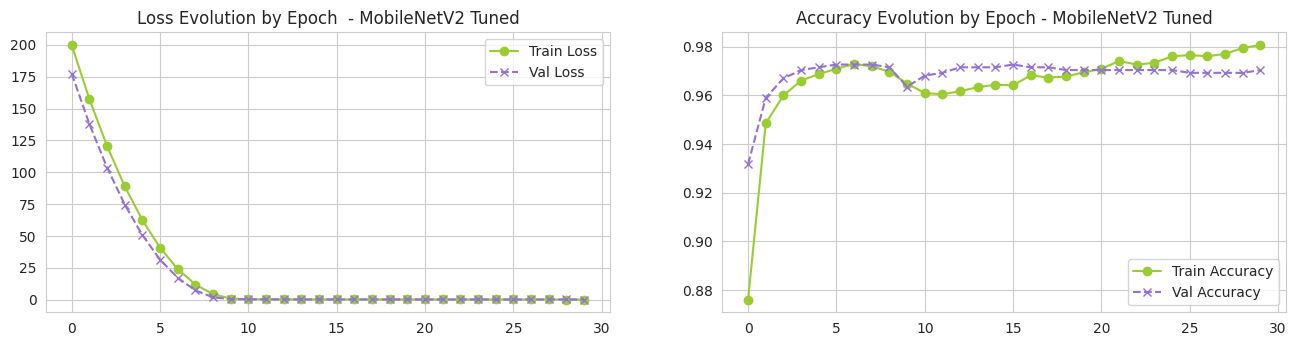

time: 445 ms (started: 2024-06-18 19:13:34 +00:00)


In [ ]:
# plot accuracy and loss evolution for VGG16 model
plot_history(mobv2_history, mobilenet_model_v2, 'MobileNetV2 Tuned')

Step: Loading Weights complete.
Step: Saving and Loading Model complete.
129/129 - 5s - loss: 0.1112 - binary_accuracy: 0.9822 - 5s/epoch - 38ms/step
28/28 - 1s - loss: 0.1389 - binary_accuracy: 0.9704 - 1s/epoch - 39ms/step
28/28 - 1s - loss: 0.1548 - binary_accuracy: 0.9636 - 1s/epoch - 38ms/step

MobileNetV2 Tuned: Loss and Accuracy Values 
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
               Model  Train Loss  Val Loss  Test Loss  Train Accuracy  \
0  MobileNetV2 Tuned    0.111199  0.138917   0.154825        0.982191   

   Val Accuracy  Test Accuracy  
0      0.970421       0.963554  


Step: Evaluate Model Accuracy and Loss complete.
MobileNet50v2 Tuned - Classification Report 
              precision    recall  f1-score   support

      normal       0.96      0.90      0.93       237
   pneumonia       0.96      0.99      0.98       641

    accuracy                           0.96       878
   macro avg       0.96      0.94      0.95       8

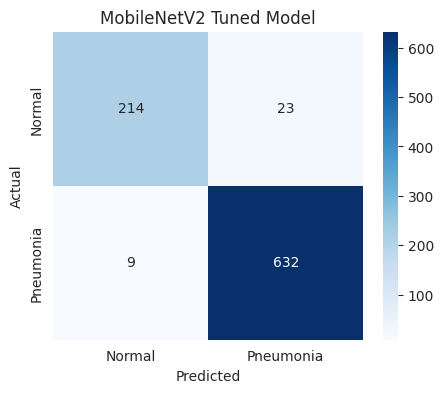

---------------------------------------------------------------------------------
Pneumonia cases incorrectly classified as Pneumonia, its actually Normal: 23
Normal cases incorrectly classified as Normal, its actually Pneumonia: 9

---------------------------------------------------------------------------------
Pretrained Model Performance (MobileNetV2 Tuned):

               Model  Accuracy  Precision  Recall  F1-Score  FP  FN   TP   TN
0  MobileNetV2 Tuned     96.36      96.49    98.6     97.53  23   9  632  214

---------------------------------------------------------------------------------
AUC-ROC: 0.9444565124377127


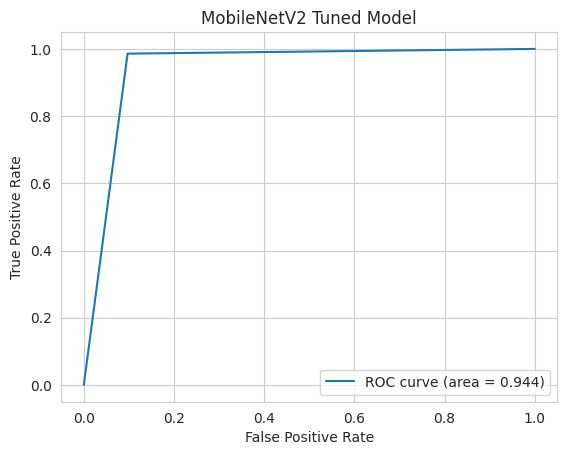

time: 12.7 s (started: 2024-06-18 18:36:40 +00:00)


In [ ]:
### Load Weights
mobilenet_model_v2.load_weights(mobilev2_model_checkpoint)
print('Step: Loading Weights complete.')
tf.keras.backend.clear_session()  # clear tf session

#saving model
mobilenet_model_v2.save('mobilenet_model_v2.keras')
print('Step: Saving and Loading Model complete.')

# Evaluate model accuracy and loss (model.evaluate)
mobv2_loss_metrics_df = evaluate_loss_accuracy(mobilenet_model_v2, 'MobileNetV2 Tuned')
print('Step: Evaluate Model Accuracy and Loss complete.')

#--------------------------------------------------------------------------------------#
# Predict on Test/Unseen Data
#--------------------------------------------------------------------------------------#
# Call Function to Predict on Test Data and Generate Classification Report
class_report_mob_v2, y_actual_mobv2, y_predicted_mobv2 = get_model_predictions(mobilenet_model_v2, testing_ds)
print("MobileNet50v2 Tuned - Classification Report \n=================================================================")
print(class_report_mob_v2)
print('\nStep: Predicting on Test Dataset complete.')

#--------------------------------------------------------------------------------------#
# Performance Evaluation
#--------------------------------------------------------------------------------------#
# Get Metrics for MobileNetV2 Model
mobv2_performance_df = evaluate_model_performance(mobilenet_model_v2, y_actual_mobv2, y_predicted_mobv2, 'MobileNetV2 Tuned')
print('Pretrained Model Performance (MobileNetV2 Tuned):\n')
print(mobv2_performance_df)
print('\n---------------------------------------------------------------------------------')

# CALL function to plot auc-roc curve
mobv2_auc = plot_roc_curve(y_actual_mobv2, y_predicted_mobv2, 'MobileNetV2 Tuned')

In [ ]:
# Add the AUC column to the DataFrame
mobv2_performance_df['AUC'] = mobv2_auc
mobv2_performance_df['Train Time'] = round(mobv2_train_time, 2)
mobv2_performance_df

Model  Accuracy  Precision  Recall  F1-Score  FP  FN   TP   TN  \
0  MobileNetV2 Tuned     96.36      96.49    98.6     97.53  23   9  632  214   

     AUC  Train Time  
0  0.944      197.34

time: 20.3 ms (started: 2024-06-18 18:37:14 +00:00)


# Section 8: Performance Comparison/Evaluation

In [ ]:
#--------------------------------------------------------------------------------------#
# CONCAT METRICS ALL MODELS
#--------------------------------------------------------------------------------------#
# Concatenate the DataFrames
merged_metrics_df = pd.concat([cnn_performance_df,
                               convv2_performance_df,
                               vgg16_performance_df,
                               vgg16v2_performance_df,
                               resnet_performance_df,
                               resv2_performance_df,
                               mobilenet_performance_df,
                               mobv2_performance_df
                               ]
                              , ignore_index=True)

# Print the merged DataFrame
merged_metrics_df

Model  Accuracy  Precision  Recall  F1-Score  FP  FN   TP   TN  \
0           Conv CNN     96.13      96.62   98.13     97.37  22  12  629  215   
1      ConvCNN Tuned     97.15      97.24   98.91     98.07  18   7  634  219   
2              VGG16     96.70      97.37   98.13     97.75  17  12  629  220   
3        VGG16 Tuned     96.36      97.06   97.97     97.52  19  13  628  218   
4           ResNetV2     96.13      96.91   97.82     97.36  20  14  627  217   
5   ResNet50v2 Tuned     96.92      97.38   98.44     97.91  17  10  631  220   
6        MobileNetV2     96.01      96.90   97.66     97.28  20  15  626  217   
7  MobileNetV2 Tuned     96.36      96.49   98.60     97.53  23   9  632  214   

     AUC  Train Time  
0  0.944      570.73  
1  0.957      586.97  
2  0.955      732.51  
3  0.950      738.61  
4  0.947      424.05  
5  0.956      429.02  
6  0.955      191.69  
7  0.944      197.34

time: 27.4 ms (started: 2024-06-18 18:38:14 +00:00)


In [ ]:
#--------------------------------------------------------------------------------------#
# CONCAT LOSS AND ACCURACY RESULTS
#--------------------------------------------------------------------------------------#
# Concatenate the DataFrames
merged_loss_acc_df = pd.concat([cnn_loss_metrics_df,
                                convv2_loss_metrics_df,
                                vgg16_loss_metrics_df,
                                vgg16v2_loss_metrics_df,
                                resnet_loss_metrics_df,
                                resv2_loss_metrics_df,
                                mobilenet_loss_metrics_df,
                                mobv2_loss_metrics_df
                               ]
                              , ignore_index=True)

# Print the merged DataFrame and round accuracies
merged_loss_acc_df['Train Accuracy'] = (merged_loss_acc_df['Train Accuracy'] * 100).round(2)
merged_loss_acc_df['Test Accuracy'] = (merged_loss_acc_df['Test Accuracy'] * 100).round(2)
merged_loss_acc_df['Val Accuracy'] = (merged_loss_acc_df['Val Accuracy'] * 100).round(2)
merged_loss_acc_df['Accuracy Diff'] = merged_loss_acc_df['Train Accuracy'] - merged_loss_acc_df['Test Accuracy']
merged_loss_acc_df

Model  Train Loss  Val Loss  Test Loss  Train Accuracy  \
0           Conv CNN    0.089696  0.135877   0.132700           97.80   
1      ConvCNN Tuned    0.016934  0.103349   0.099705          100.00   
2              VGG16    0.110244  0.133945   0.141947           97.61   
3        VGG16 Tuned    0.203973  0.206293   0.209483           96.34   
4         ResNet50V2    0.055570  0.133609   0.135991           99.02   
5   ResNet50v2 Tuned    0.141749  0.186434   0.190955           98.80   
6        MobileNetV2    0.077503  0.129001   0.135991           98.29   
7  MobileNetV2 Tuned    0.111199  0.138917   0.154825           98.22   

   Val Accuracy  Test Accuracy  Accuracy Diff  
0         96.59          96.13           1.67  
1         96.93          97.15           2.85  
2         96.13          96.70           0.91  
3         95.68          96.36          -0.02  
4         96.25          96.13           2.89  
5         96.47          96.92           1.88  
6         96.36          96.01           2.28  
7         97.04          96.36           1.86

time: 22.9 ms (started: 2024-06-18 19:37:21 +00:00)


In [ ]:
#--------------------------------------------------------------------------------------#
# Display Combined Performance Metrics Dataframe
#--------------------------------------------------------------------------------------#
final_metrics = merged_metrics_df
final_metrics.sort_values(by='FN', ascending=True)

Model  Accuracy  Precision  Recall  F1-Score  FP  FN   TP   TN  \
1      ConvCNN Tuned     97.15      97.24   98.91     98.07  18   7  634  219   
7  MobileNetV2 Tuned     96.36      96.49   98.60     97.53  23   9  632  214   
5   ResNet50v2 Tuned     96.92      97.38   98.44     97.91  17  10  631  220   
0           Conv CNN     96.13      96.62   98.13     97.37  22  12  629  215   
2              VGG16     96.70      97.37   98.13     97.75  17  12  629  220   
3        VGG16 Tuned     96.36      97.06   97.97     97.52  19  13  628  218   
4           ResNetV2     96.13      96.91   97.82     97.36  20  14  627  217   
6        MobileNetV2     96.01      96.90   97.66     97.28  20  15  626  217   

     AUC  Train Time  
1  0.957      586.97  
7  0.944      197.34  
5  0.956      429.02  
0  0.944      570.73  
2  0.955      732.51  
3  0.950      738.61  
4  0.947      424.05  
6  0.955      191.69

time: 25.2 ms (started: 2024-06-18 18:47:30 +00:00)


#### Which Models Performed best in each area?

In [ ]:
#--------------------------------------------------------------------------------------#
# Accuracy
#--------------------------------------------------------------------------------------#
# Get row with the highest Accuracy
print("Model with the Highest Accuracy:")
final_metrics[final_metrics['Accuracy'] == final_metrics['Accuracy'].max()]

Model with the Highest Accuracy:


Model  Accuracy  Precision  Recall  F1-Score  FP  FN   TP   TN  \
1  ConvCNN Tuned     97.15      97.24   98.91     98.07  18   7  634  219   

     AUC  Train Time  
1  0.957      586.97

time: 22.6 ms (started: 2024-06-18 18:47:45 +00:00)


In [ ]:
print("Models Sorted by Accuracy:")
highestacc = final_metrics[['Model', 'Accuracy']].nlargest(4, 'Accuracy')
highestacc.sort_values(by='Accuracy', ascending=False)

Models Sorted by Accuracy:


Model  Accuracy
1     ConvCNN Tuned     97.15
5  ResNet50v2 Tuned     96.92
2             VGG16     96.70
3       VGG16 Tuned     96.36

time: 12.8 ms (started: 2024-06-18 18:47:53 +00:00)


In [ ]:
#--------------------------------------------------------------------------------------#
# 6.2 F1-Score
#--------------------------------------------------------------------------------------#
# Get row with the highest F1-Score
print(f"Model with the Highest F1-Score:\n")
final_metrics[final_metrics['F1-Score'] == final_metrics['F1-Score'].max()]

Model with the Highest F1-Score:



Model  Accuracy  Precision  Recall  F1-Score  FP  FN   TP   TN  \
1  ConvCNN Tuned     97.15      97.24   98.91     98.07  18   7  634  219   

     AUC  Train Time  
1  0.957      586.97

time: 21.1 ms (started: 2024-06-18 18:48:02 +00:00)


In [ ]:
#--------------------------------------------------------------------------------------#
# 6.3 Recall
#--------------------------------------------------------------------------------------#
# Get row with the highest Recall
print(f"Model with the Highest Recall:\n")
final_metrics[final_metrics['Recall'] == final_metrics['Recall'].max()]

Model with the Highest Recall:



Model  Accuracy  Precision  Recall  F1-Score  FP  FN   TP   TN  \
1  ConvCNN Tuned     97.15      97.24   98.91     98.07  18   7  634  219   

     AUC  Train Time  
1  0.957      586.97

time: 22.2 ms (started: 2024-06-18 18:48:15 +00:00)


In [ ]:
#--------------------------------------------------------------------------------------#
# 6.4 Precision
#--------------------------------------------------------------------------------------#
# Get row with the highest Precision
print(f"Model with the Highest Precision:\n")
final_metrics[final_metrics['Precision'] == final_metrics['Precision'].max()]

Model with the Highest Precision:



Model  Accuracy  Precision  Recall  F1-Score  FP  FN   TP   TN  \
5  ResNet50v2 Tuned     96.92      97.38   98.44     97.91  17  10  631  220   

     AUC  Train Time  
5  0.956      429.02

time: 20.8 ms (started: 2024-06-18 18:48:20 +00:00)


In [ ]:
#--------------------------------------------------------------------------------------#
# 6.5 False Positive
#--------------------------------------------------------------------------------------#
# Get row with the lowest false postive value
print("Models with Lowest False Positives")
print("Note: Normal classes incorrectly classified as Pneumonia. \n")
lowestfp = final_metrics[['Model', 'FP', 'FN']].nsmallest(3, 'FP')
lowestfp.sort_values(by='FP', ascending=True)

Models with Lowest False Positives
Note: Normal classes incorrectly classified as Pneumonia. 



Model  FP  FN
2             VGG16  17  12
5  ResNet50v2 Tuned  17  10
1     ConvCNN Tuned  18   7

time: 14.1 ms (started: 2024-06-18 18:48:27 +00:00)


In [ ]:
#--------------------------------------------------------------------------------------#
# 6.6 False Negatives
#--------------------------------------------------------------------------------------#
# Get row with the lowest false negative value
print("Models with Lowest False Negatives")
print("Note: Pneumonia classes incorrectly classified as Normal. \n")
lowestfp = final_metrics[['Model', 'FN', 'FP']].nsmallest(3, 'FN')
lowestfp.sort_values(by='FN', ascending=True)

Models with Lowest False Negatives
Note: Pneumonia classes incorrectly classified as Normal. 



Model  FN  FP
1      ConvCNN Tuned   7  18
7  MobileNetV2 Tuned   9  23
5   ResNet50v2 Tuned  10  17

time: 14.2 ms (started: 2024-06-18 18:48:55 +00:00)


In [ ]:
# interpolate cmap values for plots
cmap = mat.cm.Blues(np.linspace(0,1,100))
cmapblues = mat.colors.ListedColormap(cmap[30:-3])

cmap = mat.cm.Purples(np.linspace(0,1,100))
cmappurples = mat.colors.ListedColormap(cmap[30:-3])

cmap = mat.cm.Greens(np.linspace(0,1,100))
cmapgreens = mat.colors.ListedColormap(cmap[30:-3])

cmap = mat.cm.Oranges(np.linspace(0,1,100))
cmaporanges = mat.colors.ListedColormap(cmap[10:-1])

time: 1.37 ms (started: 2024-06-19 03:45:05 +00:00)


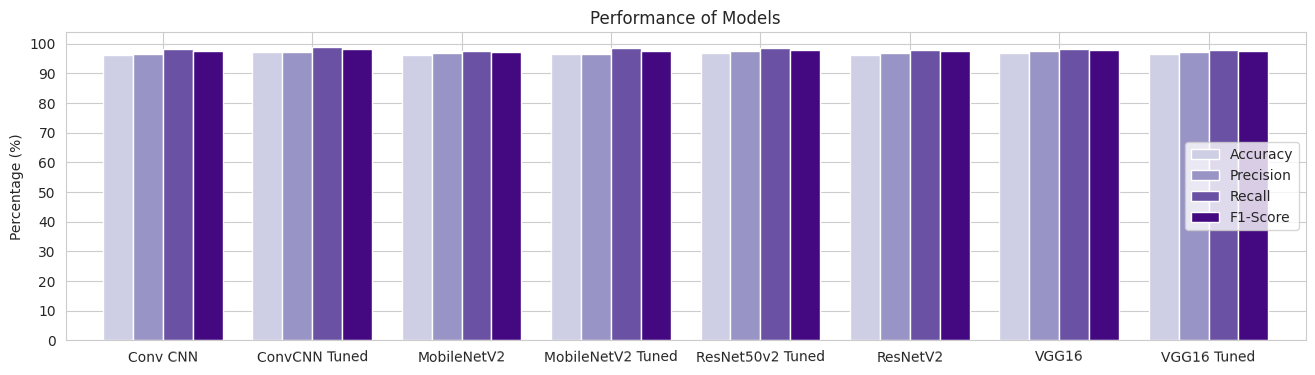

time: 292 ms (started: 2024-06-18 19:42:55 +00:00)


In [ ]:
#--------------------------------------------------------------------------------------#
# Visualize: Comparison of Model Performances
#--------------------------------------------------------------------------------------#
# plot a graph to compare metrics visually
eval_metrics = final_metrics.iloc[:,0:5]
eval_metrics.sort_values(by="Model", ascending=True, inplace=True)
#eval_metrics.reset_index(drop=True, inplace=True

metrics_plot = eval_metrics.plot.bar(cmap = cmappurples,
                figsize=(16, 4),
                width = 0.8,
                grid=False)
metrics_plot.set_xticklabels(eval_metrics['Model'])

plt.xticks(rotation=0.45)
plt.yticks(np.arange(0,101, 10))        #calculate a range of numbers from 0, 100 with a step 10
plt.ylabel("Percentage (%)")
plt.xlabel(None)
plt.grid(True)
plt.legend(loc='center right', ncols=1)
plt.title(f'Performance of Models')
plt.show()

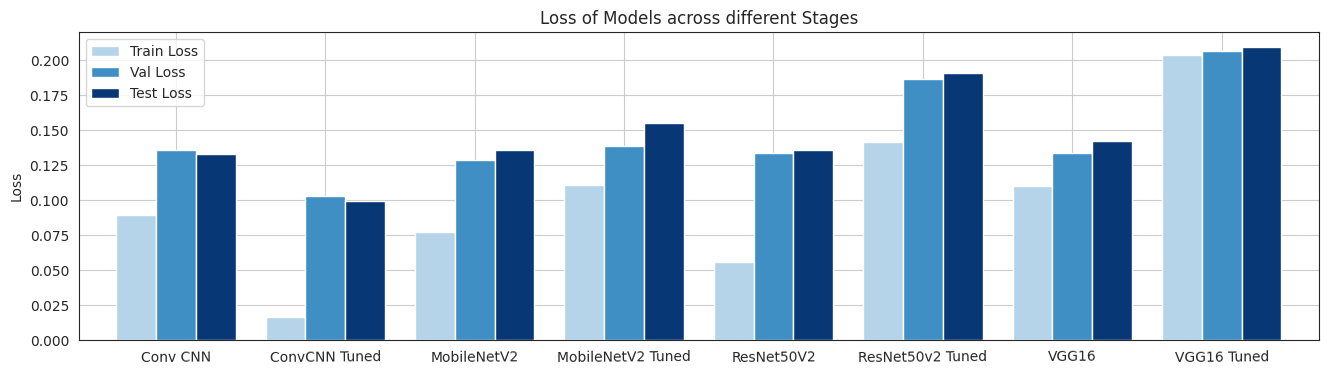

time: 257 ms (started: 2024-06-19 03:45:55 +00:00)


In [ ]:
#--------------------------------------------------------------------------------------#
# Visualize: Loss of Models across different Stages (model.evaluate())
#--------------------------------------------------------------------------------------#
# plot a graph to compare metrics visually
eval_loss = merged_loss_acc_df.iloc[:,0:4]
eval_loss.sort_values(by="Model", ascending=True, inplace=True)

metrics_plot = eval_loss.plot.bar(cmap = cmapblues,
                figsize=(16, 4),
                width = 0.8,
                grid=False)
metrics_plot.set_xticklabels(eval_loss['Model'])

plt.xticks(rotation=0.45)
plt.ylabel("Loss")
plt.xlabel(None)
plt.grid(True)
plt.legend(loc='upper left', ncols=1)
plt.title(f'Loss of Models across different Stages')
plt.show()

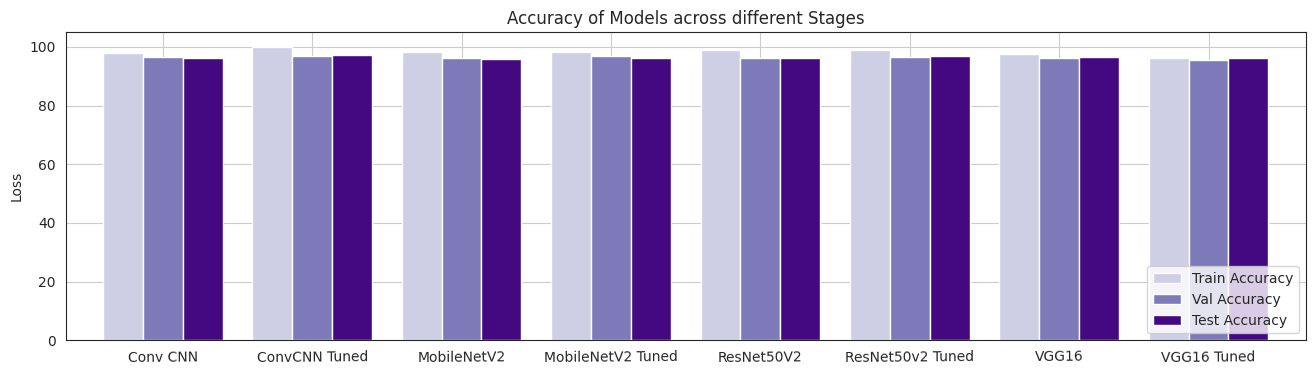

time: 250 ms (started: 2024-06-19 03:52:05 +00:00)


In [ ]:
#--------------------------------------------------------------------------------------#
# Visualize: Accuracy of Models across different Stages (model.evaluate())
#--------------------------------------------------------------------------------------#
# plot a graph to compare metrics visually
eval_acc = merged_loss_acc_df[['Model', 'Train Accuracy','Val Accuracy','Test Accuracy']].copy()
eval_acc.sort_values(by="Model", ascending=True, inplace=True)

metrics_plot = eval_acc.plot.bar(cmap = cmappurples,
                figsize=(16, 4),
                width = 0.8,
                grid=False)
metrics_plot.set_xticklabels(eval_acc['Model'])

plt.xticks(rotation=0.45)
plt.ylabel("Loss")
plt.xlabel(None)
plt.grid(True)
plt.legend(loc='lower right', ncols=1)
plt.title(f'Accuracy of Models across different Stages')
plt.show()

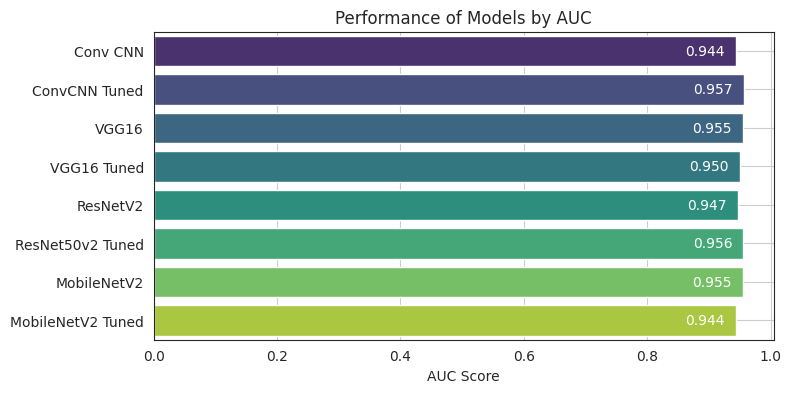

time: 262 ms (started: 2024-06-18 20:55:26 +00:00)


In [ ]:
# Prepare the data
eval_AUC = final_metrics[['Model', 'AUC']]
#eval_AUC = eval_AUC.sort_values(by="AUC", ascending=False)

# Create the Seaborn bar plot
plt.figure(figsize=(8, 4))
sns.barplot(x='AUC', y='Model', data=eval_AUC, hue='Model', palette='viridis', errorbar=None, orient='h')

# Customize the plot
plt.xticks(rotation=0)
plt.xlabel("AUC Score")
plt.ylabel(None)
plt.title('Performance of Models by AUC')
plt.grid(True)

# Add text values above bars
for i in eval_AUC.index:
    plt.text(eval_AUC['AUC'][i] + -0.05, i, f'{eval_AUC["AUC"][i]:.3f}', ha='center', va='center', color='white')
# Show the plot
plt.show()

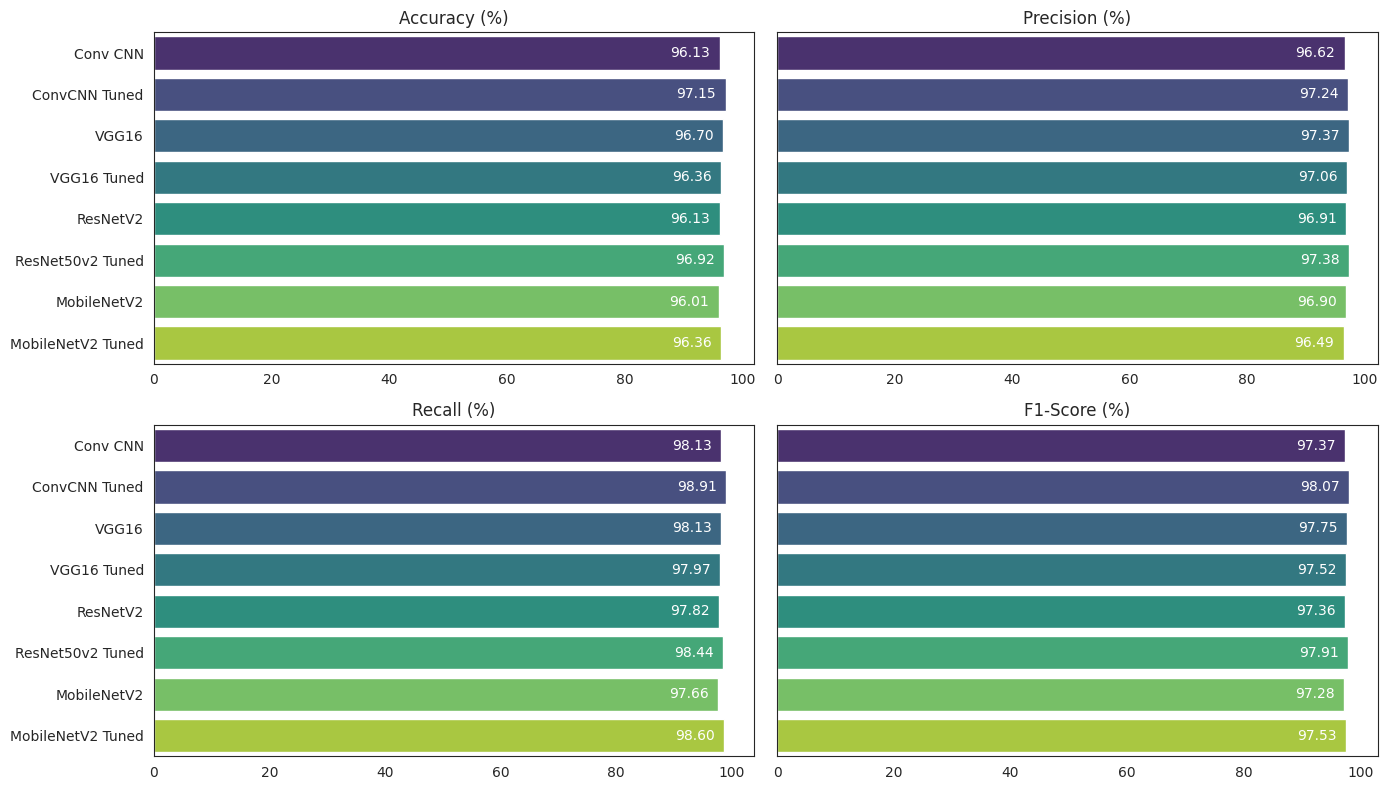

time: 1.08 s (started: 2024-06-18 20:20:21 +00:00)


In [ ]:
# Set up the figure and axes for subplots
sns.set_style("white")
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
df = merged_metrics_df
# Function to add text values at the end of each bar
def add_value_labels(ax):
    for patch in ax.patches:
        ax.text(patch.get_width() -5, patch.get_y() + patch.get_height() / 2,
                f'{patch.get_width():.2f}', ha='center', va='center', color='white')

# Plot Accuracy
sns.barplot(x='Accuracy', y='Model', data=df, ax=axes[0, 0], hue='Model', palette='viridis', errorbar=None, orient='h')
axes[0, 0].set_title('Accuracy (%)')
axes[0, 0].set_ylabel(None)
axes[0, 0].set_xlabel(None)
add_value_labels(axes[0, 0])

# Plot Precision
sns.barplot(x='Precision', y='Model', data=df, ax=axes[0, 1], hue='Model', palette='viridis', errorbar=None, orient='h')
axes[0, 1].set_title('Precision (%)')
axes[0, 1].set_ylabel(None)
axes[0, 1].set_xlabel(None)
axes[0, 1].set_yticklabels([])
add_value_labels(axes[0, 1])

# Plot Recall
sns.barplot(x='Recall', y='Model', data=df, ax=axes[1, 0], hue='Model', palette='viridis', errorbar=None, orient='h')
axes[1, 0].set_title('Recall (%)')
axes[1, 0].set_ylabel(None)
axes[1, 0].set_xlabel(None)
add_value_labels(axes[1, 0])

# Plot F1-Score
sns.barplot(x='F1-Score', y='Model', data=df, ax=axes[1, 1], hue='Model', palette='viridis', errorbar=None, orient='h')
axes[1, 1].set_title('F1-Score (%)')
axes[1, 1].set_ylabel(None)
axes[1, 1].set_xlabel(None)
axes[1, 1].set_yticklabels([])
add_value_labels(axes[1, 1])

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
final_metrics.columns

Index(['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'FP', 'FN',
       'TP', 'TN', 'AUC', 'Train Time'],
      dtype='object')

time: 3.48 ms (started: 2024-06-18 19:35:02 +00:00)


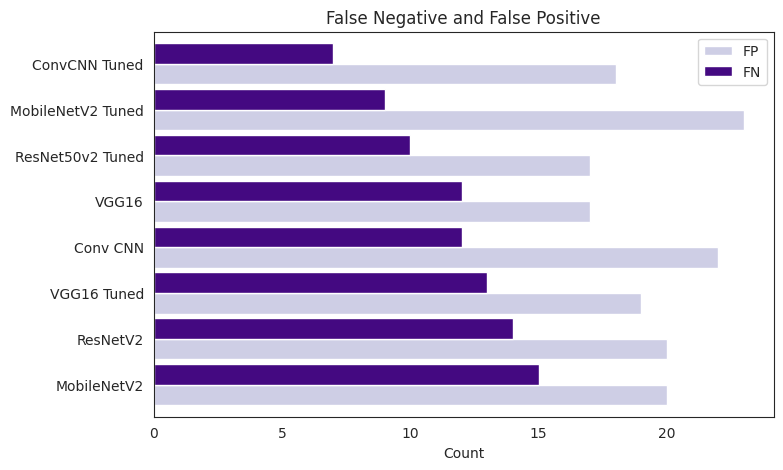

time: 261 ms (started: 2024-06-18 20:24:27 +00:00)


In [ ]:
# plot the false positive and false negative
false_rates = final_metrics.copy()
false_rates = false_rates[['Model','FP','FN']]
false_rates.sort_values(by="FN", ascending=False, inplace=True)

# vizualize results in a bar chart
false_rates.plot(x='Model',
        kind='barh',
        stacked=False,
        title='False Negative and False Positive',
        cmap=cmappurples,
        figsize=(8, 5),
        align='center',
        width = 0.9 )
plt.xticks(rotation=0)
plt.xlabel("Count")
plt.ylabel(None)
plt.legend(loc='best', ncols=1)
plt.show()

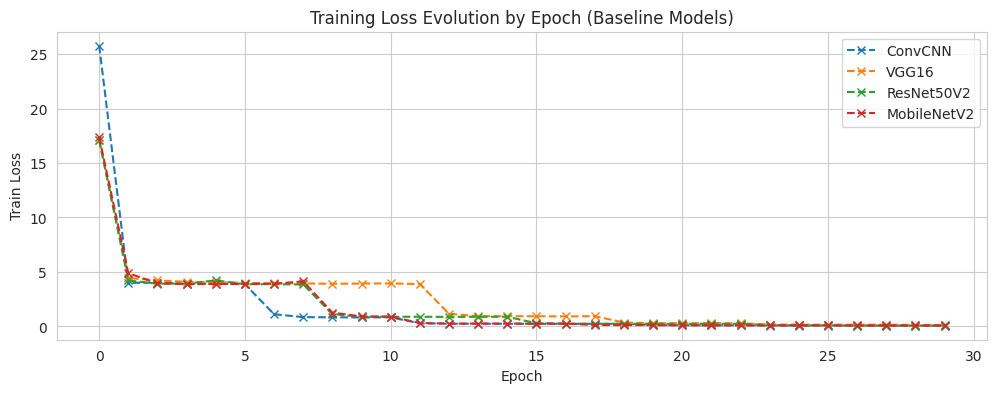

time: 253 ms (started: 2024-06-18 19:21:14 +00:00)


In [ ]:
#--------------------------------------------------------------------------------------#
# Visualize: Training Loss of CONV CNN Models vs PreTrained CNN Models
#--------------------------------------------------------------------------------------#
# plot accuracy and loss evolution for a model
plt.figure(figsize=(12, 4))
plt.plot(cnn_history.history['loss'], label='ConvCNN', linestyle='dashed', marker='x')
plt.plot(vgg16_history.history['loss'], label='VGG16', linestyle='dashed', marker='x')
plt.plot(resnet_history.history['loss'], label='ResNet50V2', linestyle='dashed', marker='x')
plt.plot(mobilenet_history.history['loss'], label='MobileNetV2', linestyle='dashed', marker='x')
plt.legend()
plt.title(f'Training Loss Evolution by Epoch (Baseline Models)')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
#plt.ylim(0, 1.5)  # Set the y-axis limits to zoom in
plt.show()

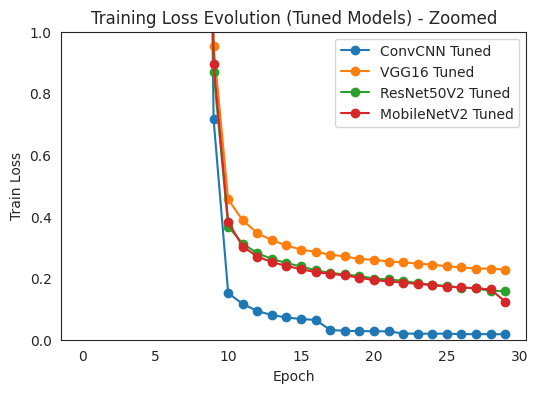

time: 227 ms (started: 2024-06-18 20:53:23 +00:00)


In [ ]:
#--------------------------------------------------------------------------------------#
# Visualize: Training Loss of CONV CNN Models vs PreTrained CNN Models
#--------------------------------------------------------------------------------------#
# plot accuracy and loss evolution for a model
plt.figure(figsize=(6, 4))
#tuned models
plt.plot(convv2_history.history['loss'], label='ConvCNN Tuned', linestyle='solid', marker='o')
plt.plot(vgg16v2_history.history['loss'], label='VGG16 Tuned', linestyle='solid', marker='o')
plt.plot(resv2_history.history['loss'], label='ResNet50V2 Tuned', linestyle='solid', marker='o')
plt.plot(mobv2_history.history['loss'], label='MobileNetV2 Tuned', linestyle='solid', marker='o')
plt.legend()
plt.title(f'Training Loss Evolution (Tuned Models) - Zoomed')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.ylim(0, 1)  # Set the y-axis limits to zoom in
plt.show()

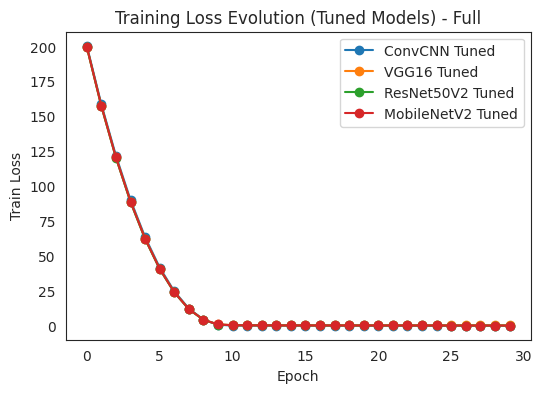

time: 279 ms (started: 2024-06-18 20:53:30 +00:00)


In [ ]:
#--------------------------------------------------------------------------------------#
# Visualize: Training Loss of CONV CNN Models vs PreTrained CNN Models
#--------------------------------------------------------------------------------------#
# plot accuracy and loss evolution for a model
plt.figure(figsize=(6, 4))
#tuned models
plt.plot(convv2_history.history['loss'], label='ConvCNN Tuned', linestyle='solid', marker='o')
plt.plot(vgg16v2_history.history['loss'], label='VGG16 Tuned', linestyle='solid', marker='o')
plt.plot(resv2_history.history['loss'], label='ResNet50V2 Tuned', linestyle='solid', marker='o')
plt.plot(mobv2_history.history['loss'], label='MobileNetV2 Tuned', linestyle='solid', marker='o')
plt.legend()
plt.title(f'Training Loss Evolution (Tuned Models) - Full')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
#plt.ylim(0, 1)  # Set the y-axis limits to zoom in
plt.show()

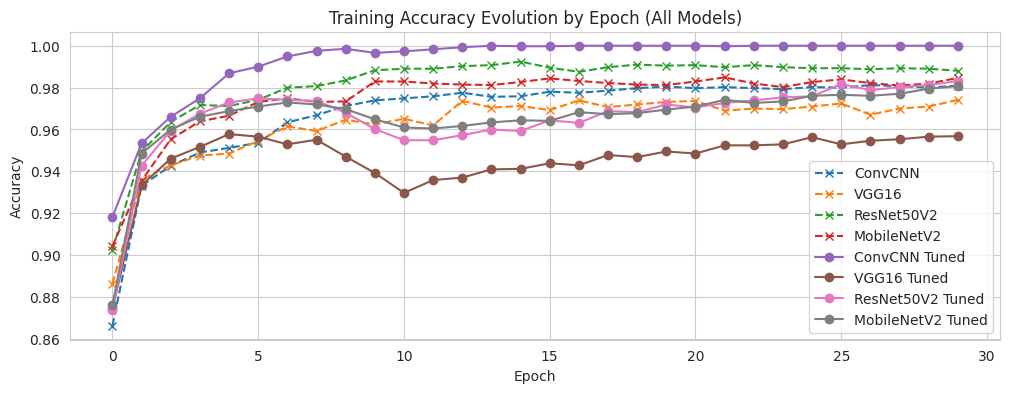

time: 307 ms (started: 2024-06-18 18:56:18 +00:00)


In [ ]:
#--------------------------------------------------------------------------------------#
# Visualize: Training Accuracy Loss of CONV CNN Models vs PreTrained CNN Models
#--------------------------------------------------------------------------------------#
# plot accuracy and loss evolution for a model
plt.figure(figsize=(12, 4))
plt.plot(cnn_history.history['binary_accuracy'], label='ConvCNN', linestyle='dashed', marker='x')
plt.plot(vgg16_history.history['binary_accuracy'], label='VGG16', linestyle='dashed', marker='x')
plt.plot(resnet_history.history['binary_accuracy'], label='ResNet50V2', linestyle='dashed', marker='x')
plt.plot(mobilenet_history.history['binary_accuracy'], label='MobileNetV2', linestyle='dashed', marker='x')
#tuned models
plt.plot(convv2_history.history['binary_accuracy'], label='ConvCNN Tuned', linestyle='solid', marker='o')
plt.plot(vgg16v2_history.history['binary_accuracy'], label='VGG16 Tuned', linestyle='solid', marker='o')
plt.plot(resv2_history.history['binary_accuracy'], label='ResNet50V2 Tuned', linestyle='solid', marker='o')
plt.plot(mobv2_history.history['binary_accuracy'], label='MobileNetV2 Tuned', linestyle='solid', marker='o')
plt.legend()
plt.title(f'Training Accuracy Evolution by Epoch (All Models)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim(0, 1.5)  # Set the y-axis limits to zoom in

plt.show()

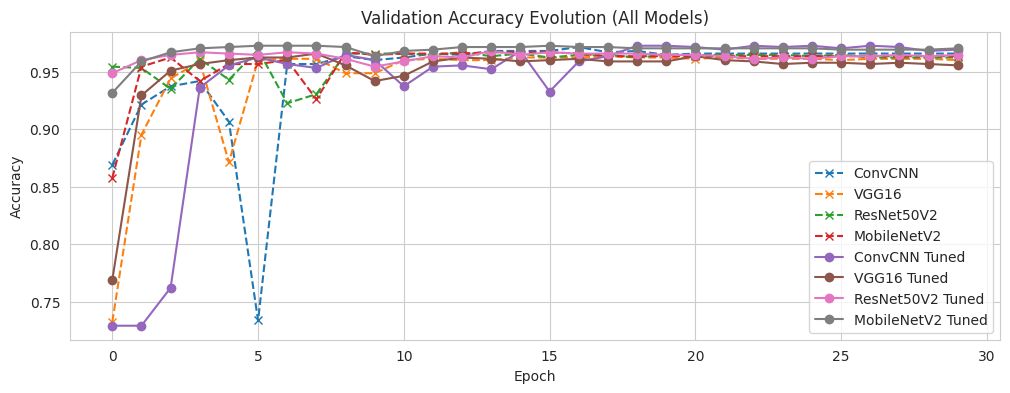

time: 287 ms (started: 2024-06-18 19:27:34 +00:00)


In [ ]:
#--------------------------------------------------------------------------------------#
# Visualize: Validation Accuracy Loss of CONV CNN Models vs PreTrained CNN Models
#--------------------------------------------------------------------------------------#
# plot accuracy and loss evolution for a model
plt.figure(figsize=(12, 4))
plt.plot(cnn_history.history['val_binary_accuracy'], label='ConvCNN', linestyle='dashed', marker='x')
plt.plot(vgg16_history.history['val_binary_accuracy'], label='VGG16', linestyle='dashed', marker='x')
plt.plot(resnet_history.history['val_binary_accuracy'], label='ResNet50V2', linestyle='dashed', marker='x')
plt.plot(mobilenet_history.history['val_binary_accuracy'], label='MobileNetV2', linestyle='dashed', marker='x')
#tuned models
plt.plot(convv2_history.history['val_binary_accuracy'], label='ConvCNN Tuned', linestyle='solid', marker='o')
plt.plot(vgg16v2_history.history['val_binary_accuracy'], label='VGG16 Tuned', linestyle='solid', marker='o')
plt.plot(resv2_history.history['val_binary_accuracy'], label='ResNet50V2 Tuned', linestyle='solid', marker='o')
plt.plot(mobv2_history.history['val_binary_accuracy'], label='MobileNetV2 Tuned', linestyle='solid', marker='o')
plt.legend()
plt.title(f'Validation Accuracy Evolution (All Models)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim(0, 1.5)  # Set the y-axis limits to zoom in

plt.show()

In [ ]:
# plot accuracy and loss evolution for a Base and Tuned Model
def compare_base_tuned_loss(model_hist_base, model_hist_tuned, model_title):
  plt.figure(figsize=(16, 6))

  plt.subplot(2, 2, 1)
  plt.plot(model_hist_base.history['loss'], label=model_title, linestyle='dashed', marker='x', color='yellowgreen')
  plt.plot(model_hist_tuned.history['loss'], label=f'{model_title} Tuned', linestyle='dashed', marker='o',color='mediumpurple')
  plt.legend(loc='upper right')
  plt.title(f'Training Loss Evolution by Epoch  - {model_title}')

  plt.subplot(2, 2, 2)
  plt.plot(model_hist_base.history['binary_accuracy'], label=model_title, linestyle='dashed', marker='x', color='yellowgreen')
  plt.plot(model_hist_tuned.history['binary_accuracy'], label=f'{model_title} Tuned', linestyle='dashed', marker='o',color='mediumpurple')
  plt.legend(loc='lower right')
  plt.title(f'Training Accuracy Evolution by Epoch - {model_title}')
  plt.show()


time: 1.26 ms (started: 2024-06-18 19:05:14 +00:00)


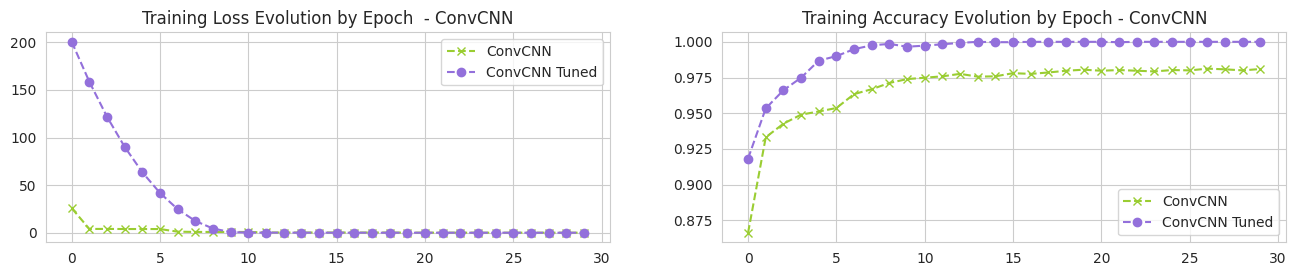

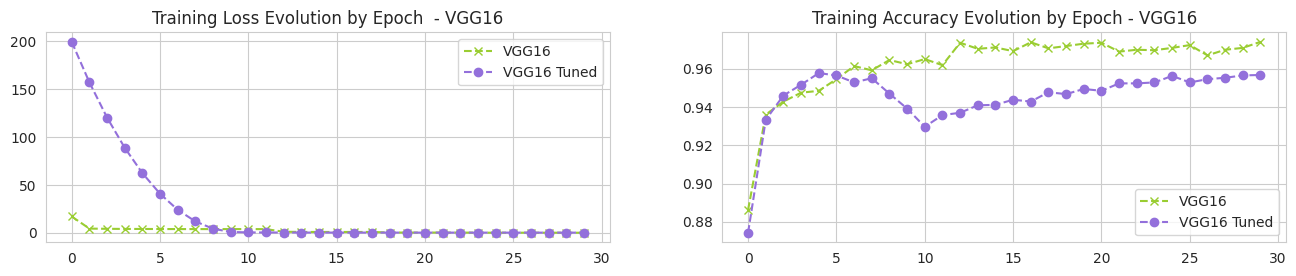

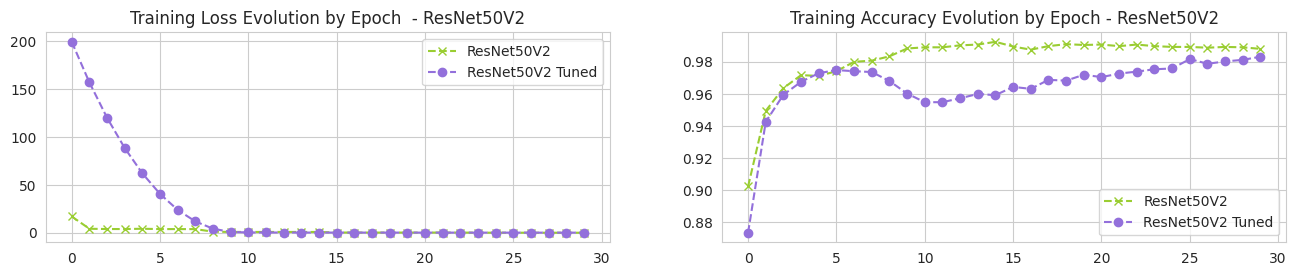

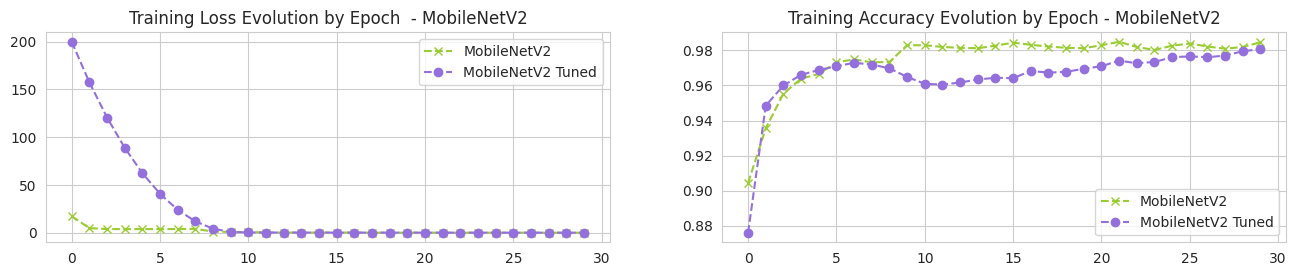

time: 2.2 s (started: 2024-06-18 19:05:18 +00:00)


In [ ]:
# call function to plot base and tuned metrics evolution
compare_base_tuned_loss(cnn_history, convv2_history, 'ConvCNN')
compare_base_tuned_loss(vgg16_history, vgg16v2_history, 'VGG16')
compare_base_tuned_loss(resnet_history, resv2_history, 'ResNet50V2')
compare_base_tuned_loss(mobilenet_history, mobv2_history, 'MobileNetV2')

In [ ]:
# plot accuracy and loss evolution for a Base and Tuned Model
def compare_base_tuned_lossval(model_hist_base, model_hist_tuned, model_title):
  plt.figure(figsize=(16, 6))

  plt.subplot(2, 2, 1)
  plt.plot(model_hist_base.history['val_loss'], label=model_title, linestyle='dashed', marker='x', color='yellowgreen')
  plt.plot(model_hist_tuned.history['val_loss'], label=f'{model_title} Tuned', linestyle='dashed', marker='o',color='mediumpurple')
  plt.legend(loc='upper right')
  plt.title(f'Validation Loss Evolution by Epoch  - {model_title}')

  plt.subplot(2, 2, 2)
  plt.plot(model_hist_base.history['val_binary_accuracy'], label=model_title, linestyle='dashed', marker='x', color='yellowgreen')
  plt.plot(model_hist_tuned.history['val_binary_accuracy'], label=f'{model_title} Tuned', linestyle='dashed', marker='o',color='mediumpurple')
  plt.legend(loc='lower right')
  plt.title(f'Validation Accuracy Evolution by Epoch - {model_title}')
  plt.show()


time: 906 µs (started: 2024-06-18 19:06:57 +00:00)


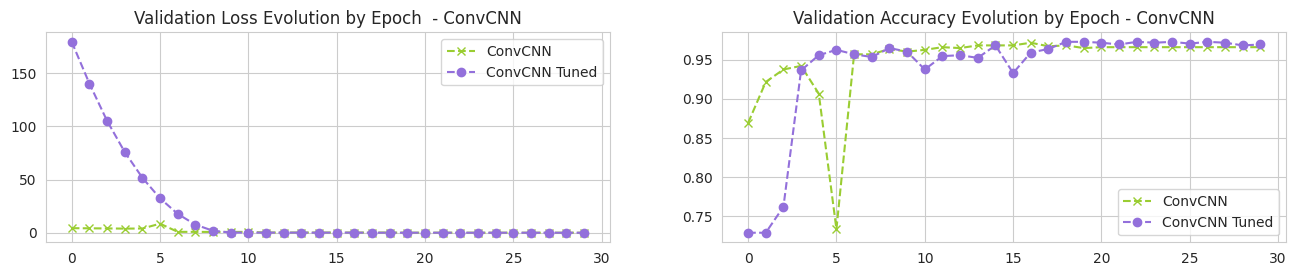

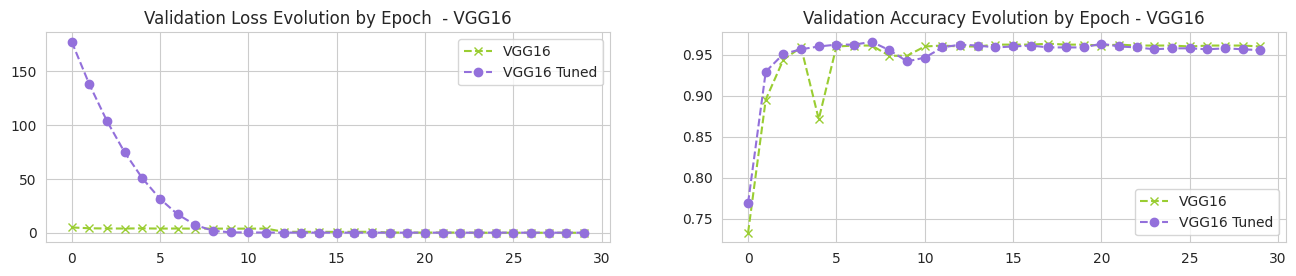

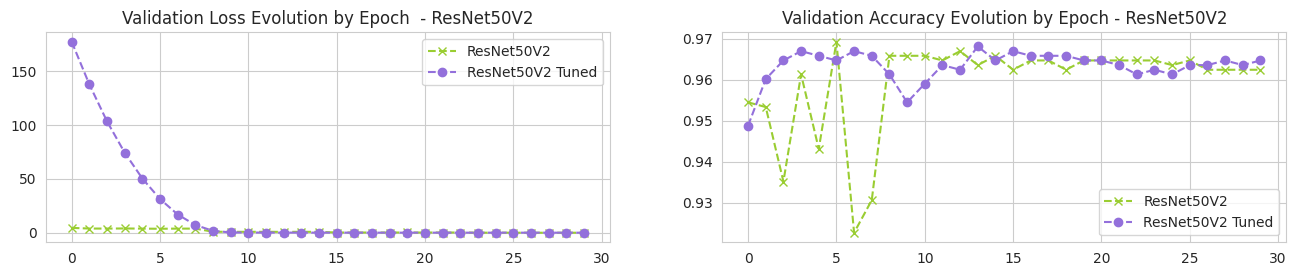

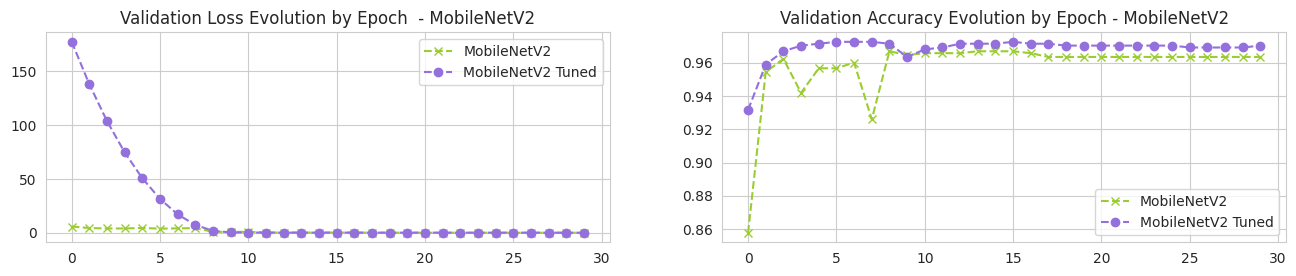

time: 1.59 s (started: 2024-06-18 19:07:01 +00:00)


In [ ]:
# call function to plot base and tuned metrics evolution
compare_base_tuned_lossval(cnn_history, convv2_history, 'ConvCNN')
compare_base_tuned_lossval(vgg16_history, vgg16v2_history, 'VGG16')
compare_base_tuned_lossval(resnet_history, resv2_history, 'ResNet50V2')
compare_base_tuned_lossval(mobilenet_history, mobv2_history, 'MobileNetV2')

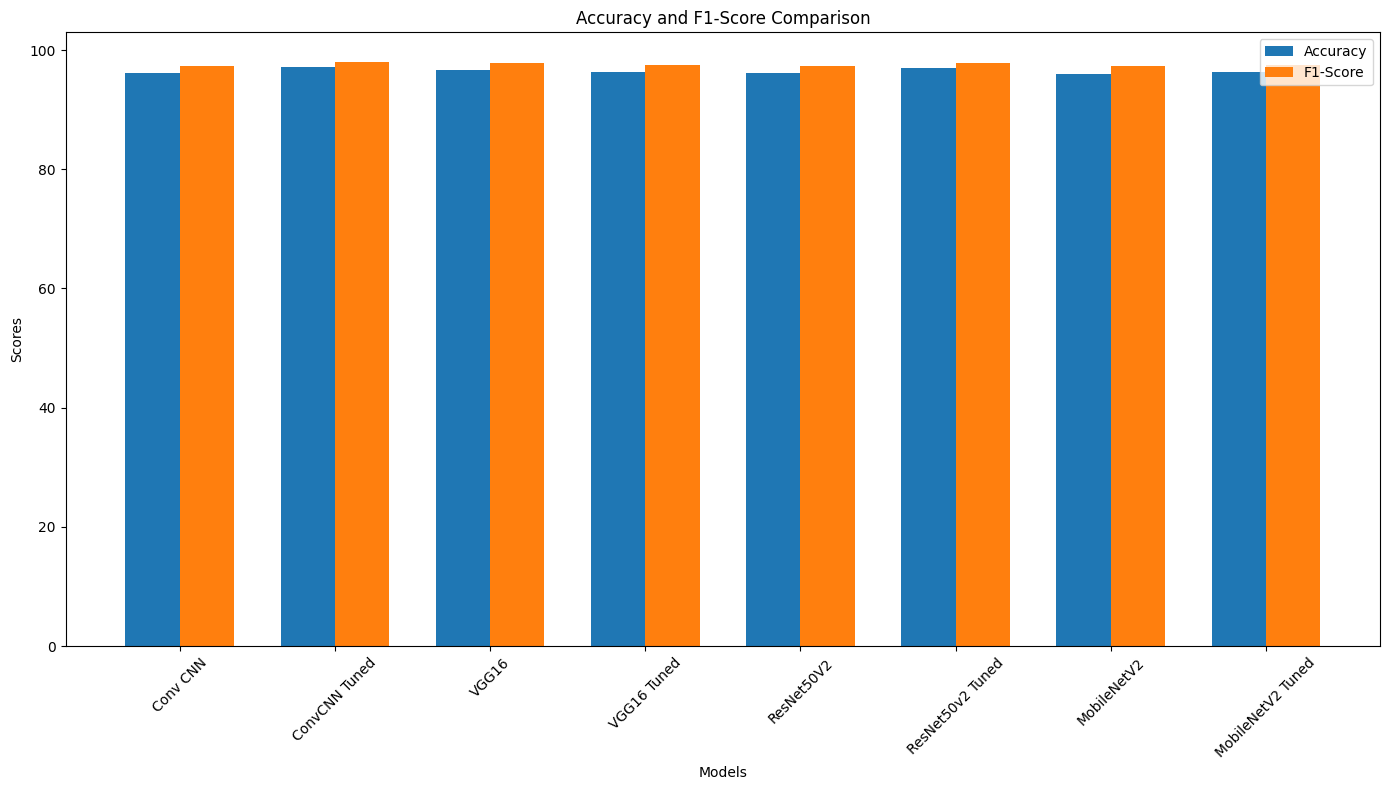

In [1]:
# Visual Aids for Key Findings
import matplotlib.pyplot as plt

models = ['Conv CNN', 'ConvCNN Tuned', 'VGG16', 'VGG16 Tuned', 'ResNet50V2', 'ResNet50v2 Tuned', 'MobileNetV2', 'MobileNetV2 Tuned']
accuracy = [96.13, 97.15, 96.70, 96.36, 96.13, 96.92, 96.01, 96.36]
f1_score = [97.37, 98.07, 97.75, 97.52, 97.36, 97.91, 97.28, 97.53]

fig, ax = plt.subplots(figsize=(14, 8))
bar_width = 0.35
index = range(len(models))

bar1 = plt.bar(index, accuracy, bar_width, label='Accuracy')
bar2 = plt.bar([i + bar_width for i in index], f1_score, bar_width, label='F1-Score')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Accuracy and F1-Score Comparison')
plt.xticks([i + bar_width / 2 for i in index], models, rotation=45)
plt.legend()
plt.tight_layout()

plt.show()